<a href="https://colab.research.google.com/github/NeKonnnn/PetProject-price-real-estate-in-St.-Petersburg/blob/main/notebooks/221202_pet_proj_property.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepaer

Вызовем необходимые библиотеки, скопируем репозиторий и откроем спарсинный файл 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder

try:
    from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
except Exception:
    !pip install catboost
    from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv

try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna

try:
    import phik
except Exception:
    !pip install phik
    import phik

try:
    import shap
except Exception:
    !pip install shap
    import shap

pd.set_option("display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.9 MB/s 
     |████████████████████████████████| 81 kB 4.9 MB/s 
     |████████████████████████████████| 209 kB 66.7 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 147 kB 56.4 MB/s 
     |████████████████████████████████| 112 kB 54.4 MB/s 
     |████████████████████████████████| 50 kB 240 kB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=1fcc79b1b6f4b12b2e5ef681f9ef6c8a5f2b806b85a72c0e56ea9010195cba7e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://

In [3]:
! git clone https://github.com/NeKonnnn/PetProject-price-real-estate-in-St.-Petersburg

Cloning into 'PetProject-price-real-estate-in-St.-Petersburg'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 44 (delta 13), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [4]:
df = pd.read_csv('/content/PetProject-price-real-estate-in-St.-Petersburg/parser/avito.csv')

# Explore

Выведем первые 5 строк датафрейма и общую информацию о нем.

In [5]:
df.head()

,id,Цена,Адрес,Ближайшее_метро,Дата_публикации,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Название_новостройки,Корпус_строение,Официальный_застройщик,Тип_участия,Срок_сдачи,Ссылка,Координаты,ВМО,Район
0,105724302,9800000,"Санкт-Петербург, Пушкинский р-н, пос. Шушары, ...",NaN,17.10.2022 в 10:16,3,73 м²,NaN,1 из 5,балкон,изолированные,NaN,раздельный,"во двор, на улицу, на солнечную сторону",косметический,NaN,NaN,NaN,NaN,свободная,NaN,кирпичный,2012.0,5.0,NaN,NaN,NaN,детская площадка,NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/3-k...,"59.737926, 30.461476",Шушары,Пушкинский
1,110963888,24000000,"Санкт-Петербург, наб. реки Фонтанки, 28",Гостиный двор11–15 мин.Невский проспект11–15 м...,17.10.2022 в 01:22,3,85 м²,NaN,3 из 5,NaN,изолированные,NaN,совмещенный,"во двор, на солнечную сторону",дизайнерский,NaN,NaN,NaN,NaN,свободная,NaN,кирпичный,NaN,5.0,NaN,открытая во дворе,NaN,закрытая территория,NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/3-k...,"59.939086, 30.343213",Литейный округ,Центральный
2,128257189,12500000,"Санкт-Петербург, Камышовая ул., 3к1",Комендантский проспект6–10 мин.Старая деревняо...,22.10.2022 в 10:29,2,55 м²,NaN,8 из 12,лоджия,изолированные,2.6 м,раздельный,на улицу,требует ремонта,кухня,NaN,NaN,NaN,альтернативная,NaN,панельный,1992.0,12.0,2,открытая во дворе,мусоропровод,NaN,нет,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/2-k...,"60.005504, 30.254046",округ Озеро Долгое,Приморский
3,139963851,14200000,"Санкт-Петербург, ул. Беринга, 1",Приморскаяот 31 мин.Василеостровскаяот 31 мин.,21.10.2022 в 16:53,1,50 м²,32 м²,17 из 17,балкон,NaN,3.4 м,совмещенный,NaN,требует ремонта,NaN,NaN,NaN,NaN,альтернативная,NaN,монолитный,2009.0,17.0,1,"подземная, за шлагбаумом во дворе",консьерж,"закрытая территория, детская площадка",1,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"59.935831, 30.249087",округ Гавань,Василеостровский
4,204005328,5500000,"Санкт-Петербург, Пулковская ул., 8к2",Звёздная6–10 мин.Купчино21–30 мин.Московская21...,16.10.2022 в 03:52,студия,26 м²,14 м²,9 из 25,балкон,NaN,2.7 м,совмещенный,"во двор, на солнечную сторону",косметический,"кухня, хранение одежды, спальные места",NaN,NaN,"холодильник, стиральная машина",свободная,возможна ипотека,монолитный,2008.0,25.0,NaN,открытая во дворе,мусоропровод,"детская площадка, спортивная площадка",NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/kva...,"59.838028, 30.352169",округ Звёздное,Московский


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20235 entries, 0 to 20234
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      20235 non-null  int64  
 1   Цена                    20235 non-null  int64  
 2   Адрес                   20231 non-null  object 
 3   Ближайшее_метро         18219 non-null  object 
 4   Дата_публикации         20235 non-null  object 
 5   Количество_комнат       20222 non-null  object 
 6   Общая_площадь           20222 non-null  object 
 7   Жилая_площадь           17389 non-null  object 
 8   Этаж                    20222 non-null  object 
 9   Балкон_или_лоджия       13758 non-null  object 
 10  Тип_комнат              9767 non-null   object 
 11  Высота_потолков         10107 non-null  object 
 12  Санузел                 15669 non-null  object 
 13  Окна                    13277 non-null  object 
 14  Ремонт                  12817 non-null

In [7]:
df.duplicated().sum()

0

Несмотря на то, что в датафрейме отсутствуют явные дубликаты, в нем могут быть и неявные, которые отличаются `id`, `временем публикации`, `ценой`.
Для анализа таких пропусков сначала посмотрим на процент уникальных значений в столбце `Адрес` 

In [8]:
df['Адрес'].nunique() / len(df)

0.36258957252285645

Более 63% объектов имеют повторяющиеся значения в адресе.
Другими словами, в среднем, каждый адрес упоминается в датафрейме 3 раза. 

Тем не менее, рассмотрение дубликатов только по одному признаку представляется нецелесообразным. 
Для повышения вероятности нахождения дубликатов рассмотрим их наличие в 3х столбцах - `Адрес`, `Общая_площадь`, `Этаж`. 

In [9]:
df[['Адрес', 'Общая_площадь', 'Этаж']].duplicated().sum() / len(df)

0.033110946380034596

Чуть более 3% данных попадают под указанный критерий, что может расцениваться как правдоподоный результат. 

## Features

Признаков очень много и в них есть пропуски.
Так как отсутсвует их описание, нужно рассмотреть каждый детально.
Для этого заполним пропуски на `no_info` и выведем уникальные значения в каждом столбце.

Выполнение указанных действий позволит разработать дальнейший план анализа.


In [10]:
df = df.fillna('no_info')

In [11]:
df['Балкон_или_лоджия'].unique()

array(['балкон', 'no_info', 'лоджия', 'балкон, лоджия'], dtype=object)

Видно, что `балкон, лоджия` - лишний признак. 
Надо ввести обработку, формирующую признаки по каждому значению - аналог One Hot Encoding.

In [12]:
df['В_доме'].unique()

array(['no_info', 'мусоропровод', 'консьерж', 'мусоропровод, газ', 'газ',
       'консьерж, мусоропровод', 'консьерж, газ',
       'консьерж, мусоропровод, газ'], dtype=object)

Аналогичный вывод про признаки

In [13]:
df['Вид_сделки'].unique()

array(['no_info', 'возможна ипотека', 'возможна ипотека, аукцион',
       'аукцион', 'продажа доли', 'возможна ипотека, продажа доли',
       'возможна ипотека, продажа доли, аукцион'], dtype=object)

Аналогичный вывод про признаки

In [14]:
df['Год_постройки'].unique()

array([2012.0, 'no_info', 1992.0, 2009.0, 2008.0, 1969.0, 2020.0, 1912.0,
       1953.0, 1968.0, 2006.0, 1982.0, 1973.0, 1960.0, 2013.0, 1910.0,
       2003.0, 2001.0, 1966.0, 1971.0, 2017.0, 2014.0, 2019.0, 2015.0,
       1965.0, 2007.0, 2018.0, 1917.0, 1986.0, 2004.0, 2021.0, 1995.0,
       2016.0, 1967.0, 1974.0, 1906.0, 1800.0, 1984.0, 2010.0, 2000.0,
       1888.0, 1989.0, 1958.0, 1962.0, 1987.0, 1860.0, 1963.0, 1949.0,
       2022.0, 1853.0, 1939.0, 1903.0, 1872.0, 1979.0, 1996.0, 1956.0,
       1972.0, 1904.0, 1998.0, 1890.0, 1955.0, 1916.0, 1935.0, 2005.0,
       1898.0, 1952.0, 1879.0, 1870.0, 1957.0, 1961.0, 1978.0, 1970.0,
       2011.0, 1977.0, 1828.0, 1999.0, 1803.0, 1954.0, 1838.0, 12.0,
       1981.0, 1983.0, 1884.0, 1988.0, 1985.0, 1959.0, 1975.0, 1933.0,
       1883.0, 1990.0, 1852.0, 1976.0, 1859.0, 1864.0, 1964.0, 1929.0,
       1881.0, 1880.0, 1836.0, 1791.0, 1980.0, 1905.0, 1940.0, 1911.0,
       2002.0, 1837.0, 1997.0, 1901.0, 1835.0, 1991.0, 1878.0, 1909.0,
     

Есть ошибки ввода.
Нужно вводить обработку.

In [15]:
df['Грузовой_лифт'].unique()

array(['no_info', 'нет', '1', '2', '4', '3'], dtype=object)

Ок

In [16]:
df['Двор'].unique()

array(['детская площадка', 'закрытая территория', 'no_info',
       'закрытая территория, детская площадка',
       'детская площадка, спортивная площадка',
       'закрытая территория, детская площадка, спортивная площадка',
       'спортивная площадка', 'закрытая территория, спортивная площадка'],
      dtype=object)

Требуется разделение признаков

In [17]:
df['Количество_комнат'].unique()

array(['3', '2', '1', 'студия', '4', '5', '7', '6', 'no_info',
       'свободная планировка', '10 и больше', '8', '9'], dtype=object)

Нужна обработка в части выделения `свободная планировка` и `no_info` в отдлеьные признаки, а в текущем признаке оставить только числовые значения.

In [18]:
df['Название_новостройки'].unique()
df['Официальный_застройщик'].unique()
df['Корпус_строение'].unique()

array(['no_info', 'Корпус 2 (Квартал 75А)', 'Корпус 1 (1 очередь)',
       'Корпус 27', 'Корпус 1', 'Корпус 2 (1 очередь)',
       '3 этап, корпус 3', 'Корпус 2 (уч. 1689, 2 этап)',
       'Корпус 3 (уч. 1689, 2 этап)',
       'Корпус 229.1-229.2 (Дом 21-22, 19 квартал)', 'Корпус 6',
       'Корпус 3.2.2', 'Корпус 3.1.2', 'Корпус Мистраль', 'Дом 24',
       'Дом 2', 'Дом 21', 'Корпус 6 (д. 9, литер В)',
       'Дом 1 (секции 1.1-1.10) (участок 1)', 'Корпус 3',
       'Корпус 327.1 (эт. 4-5, уч. 15, кв-л 26)', 'Дом 22',
       'Дом 5 (Корпус 13.2.2)', 'Корпус 1 (уч. 1689, 1 этап)',
       '3 этап, корпус 4', 'Корпус 11.4 (Дом 6)',
       'Корпус 5 (уч. 1687, 1 этап)', 'Корпус 13.1.1 (Дом 1)',
       'Дом 17 (Корпус 19.3)', 'Корпус 14.2',
       'Корпус 253.1 (эт. 28-30, уч. 132)', 'Корпус 14.4', 'Корпус 2',
       '1 очередь', 'Корпус 7.1.1', 'Корпус 2.3.1', 'Корпус 2.1.1',
       'Дом 8 (Корпус 13.2.5)', 'Блок Б3',
       'Корпус 326.2 (эт. 1-3, уч. 15, кв-л 26)', 'Корпус 1.4 (Дом 17)'

Бесполезные принзнаки, которые по смыслу дублируют адрес.

In [19]:
df['Мебель'].unique()

array(['no_info', 'кухня', 'кухня, хранение одежды, спальные места',
       'кухня, спальные места', 'хранение одежды',
       'кухня, хранение одежды', 'спальные места',
       'хранение одежды, спальные места'], dtype=object)

Требуется разделение признаков

In [20]:
df['Окна'].unique()

array(['во двор, на улицу, на солнечную сторону',
       'во двор, на солнечную сторону', 'на улицу', 'no_info',
       'во двор, на улицу', 'во двор', 'на улицу, на солнечную сторону',
       'на солнечную сторону'], dtype=object)

Требуется разделение признаков

In [21]:
df['Отделка'].unique()

array(['no_info', 'чистовая', 'предчистовая', 'без отделки'], dtype=object)

Простой категориальный признак.

In [22]:
df['Парковка'].unique()

array(['no_info', 'открытая во дворе',
       'подземная, за шлагбаумом во дворе', 'подземная',
       'за шлагбаумом во дворе',
       'подземная, открытая во дворе, за шлагбаумом во дворе',
       'открытая во дворе, за шлагбаумом во дворе',
       'подземная, наземная многоуровневая',
       'подземная, наземная многоуровневая, открытая во дворе',
       'наземная многоуровневая, открытая во дворе',
       'подземная, открытая во дворе',
       'наземная многоуровневая, за шлагбаумом во дворе',
       'наземная многоуровневая',
       'подземная, наземная многоуровневая, открытая во дворе, за шлагбаумом во дворе',
       'подземная, наземная многоуровневая, за шлагбаумом во дворе',
       'наземная многоуровневая, открытая во дворе, за шлагбаумом во дворе'],
      dtype=object)

Требуется разделение признаков

In [23]:
df['Пассажирский_лифт'].unique()

array(['no_info', '2', '1', '3', 'нет', '4'], dtype=object)

Нужна обработка в части выделения `no_info` в отдлеьный признак, а в текущем признаке оставить только числовые значения.

In [24]:
df['Ремонт'].unique()

array(['косметический', 'дизайнерский', 'требует ремонта', 'no_info',
       'евро'], dtype=object)

Простой категориальный признак.

In [25]:
df['Санузел'].unique()

array(['раздельный', 'совмещенный', 'no_info', 'совмещенный, раздельный'],
      dtype=object)

Простой категориальный признак.

In [26]:
df['Способ_продажи'].unique()

array(['свободная', 'альтернативная', 'no_info', 'переуступка',
       'договор ЖСК', 'договор долевого участия'], dtype=object)

Простой категориальный признак.

In [27]:
df['Срок_сдачи'].unique()

array(['no_info', 'сдан', '4 кв. 2022 года', '1 кв. 2023 года',
       '3 кв. 2023 года', '4 кв. 2023 года', '4 кв. 2025 года',
       '3 кв. 2022 года, сдача не подтверждена', '2 кв. 2023 года',
       '4 кв. 2024 года', '3 кв. 2024 года', '2 кв. 2024 года',
       '2 кв. 2025 года', '1 кв. 2025 года',
       '2 кв. 2022 года, сдача не подтверждена',
       '3 кв. 2019 года, сдача не подтверждена', '1 кв. 2024 года',
       '3 кв. 2025 года', '2 кв. 2026 года', '3 кв. 2026 года',
       '4 кв. 2026 года'], dtype=object)

Потребуется обработка и расчет сроков до окончания строительства.

In [28]:
df['Техника'].unique()

array(['no_info', 'холодильник, стиральная машина',
       'кондиционер, холодильник, стиральная машина',
       'холодильник, стиральная машина, посудомоечная машина, водонагреватель',
       'холодильник, стиральная машина, посудомоечная машина',
       'холодильник, стиральная машина, водонагреватель', 'холодильник',
       'посудомоечная машина', 'посудомоечная машина, водонагреватель',
       'кондиционер, холодильник, стиральная машина, посудомоечная машина, водонагреватель',
       'стиральная машина',
       'кондиционер, холодильник, посудомоечная машина, водонагреватель',
       'холодильник, водонагреватель', 'водонагреватель',
       'холодильник, посудомоечная машина', 'кондиционер',
       'стиральная машина, посудомоечная машина',
       'кондиционер, холодильник, стиральная машина, посудомоечная машина',
       'стиральная машина, посудомоечная машина, водонагреватель',
       'кондиционер, водонагреватель',
       'кондиционер, холодильник, стиральная машина, водонагре

Требуется разделение признаков

In [29]:
df['Тип_дома'].unique()

array(['кирпичный', 'панельный', 'монолитный', 'монолитно-кирпичный',
       'блочный', 'no_info', 'деревянный'], dtype=object)

Простой категориальный признак.

In [30]:
df['Тип_комнат'].unique()

array(['изолированные', 'no_info', 'изолированные, смежные', 'смежные'],
      dtype=object)

Требуется разделение признаков

In [31]:
df['Тип_участия'].unique()

array(['no_info', 'другое', 'ДДУ по ФЗ 214', 'ЖСК'], dtype=object)

Простой категориальный признак.

In [32]:
df['Тёплый_пол'].unique()

array(['no_info', 'есть'], dtype=object)

Простой категориальный признак.

In [33]:
df['Цена'].describe()

count    2.023500e+04
mean     1.350531e+07
std      8.066536e+07
min      7.689000e+03
25%      6.186144e+06
50%      8.580000e+06
75%      1.383198e+07
max      9.000000e+09
Name: Цена, dtype: float64

Большие значения - выбросы.
Маленькие значения - сдача в аренду?

In [34]:
df['Этаж'].unique()

array(['1 из 5', '3 из 5', '8 из 12', '17 из 17', '9 из 25', '1 из 9',
       '9 из 20', '9 из 24', '1 из 4', '18 из 19', '5 из 7', '5 из 6',
       '2 из 5', '1 из 8', '12 из 16', '10 из 18', '3 из 6', '6 из 14',
       '5 из 9', '6 из 12', '7 из 12', '5 из 5', '10 из 12', '12 из 17',
       '2 из 11', '25 из 25', '6 из 25', '2 из 16', '10 из 13', '6 из 9',
       '15 из 25', '11 из 24', '11 из 25', '13 из 22', '1 из 10',
       '19 из 23', '18 из 25', '21 из 25', '2 из 7', '4 из 5', '2 из 9',
       '5 из 8', '7 из 23', '14 из 23', '3 из 9', '14 из 20', '12 из 24',
       '3 из 10', '3 из 18', '19 из 26', '9 из 12', '20 из 25',
       '15 из 18', '2 из 23', '2 из 4', '23 из 26', '10 из 21', '8 из 18',
       '4 из 24', '4 из 10', '7 из 8', '8 из 23', '3 из 4', '16 из 23',
       '2 из 13', '12 из 13', '7 из 9', '12 из 12', '19 из 25',
       '13 из 13', '2 из 20', '4 из 12', '8 из 25', '1 из 25', '6 из 13',
       '14 из 24', '17 из 28', '9 из 16', '1 из 20', '20 из 23', '6 из 8',
  

Требуется обработка и выделение этажа

In [35]:
df['Этажей_в_доме'].unique()

array([5.0, 12.0, 17.0, 25.0, 9.0, 20.0, 24.0, 4.0, 19.0, 7.0, 6.0, 8.0,
       16.0, 18.0, 14.0, 11.0, 13.0, 22.0, 10.0, 23.0, 26.0, 21.0, 28.0,
       15.0, 3.0, 27.0, 29.0, 2.0, 1.0, 35.0, 'no_info', 36.0, 32.0, 33.0,
       34.0, 75.0, 40.0], dtype=object)

Дублирует Этаж


In [36]:
df['ВМО'].unique()

array(['Шушары', 'Литейный округ', 'округ Озеро Долгое', 'округ Гавань',
       'округ Звёздное', 'округ Волковское', 'Южно-Приморский округ',
       'округ Коломяги', 'округ Смольнинское', 'Владимирский округ',
       'округ Московская застава', 'округ Ульянка',
       'округ Красненькая речка', 'округ Морской', 'округ Сергиевское',
       'округ Сампсониевское', 'Невский округ', 'округ Пороховые',
       'округ Пискарёвка', 'округ № 65', 'округ Светлановское',
       'округ Юнтолово', 'округ Ланское', 'округ Малая Охта',
       'Народный округ', 'округ № 15', 'округ Правобережный',
       'округ Комендантский аэродром', 'округ Семёновский', 'Колпино',
       'округ Гражданка', 'округ Аптекарский остров', 'Финляндский округ',
       'Парголово', 'округ Сосновая поляна', 'округ Пулковский меридиан',
       'округ Лиговка-Ямская', 'no_info', 'Нарвский округ',
       'округ Полюстрово', 'округ Оккервиль', 'Петровский округ',
       'округ Чкаловское', 'округ Константиновское',
       'Ал

In [37]:
df[df['ВМО'] == 'Москва']

,id,Цена,Адрес,Ближайшее_метро,Дата_публикации,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Название_новостройки,Корпус_строение,Официальный_застройщик,Тип_участия,Срок_сдачи,Ссылка,Координаты,ВМО,Район
2230,2213502128,10900000,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,17.10.2022 в 00:23,1,40 м²,11 м²,5 из 17,лоджия,no_info,2.8 м,совмещенный,во двор,no_info,no_info,no_info,без отделки,no_info,переуступка,no_info,монолитно-кирпичный,no_info,17.0,1,открытая во дворе,no_info,закрытая территория,1,Квартал «Галактика»,"Корпус 9.1, стр. 3 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"55.797731, 37.78394",Москва,no_info
3479,2295152046,17491100,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,12.10.2022 в 20:28,2,67.8 м²,30.8 м²,5 из 18,no_info,изолированные,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/2-k...,"55.797731, 37.78394",Москва,no_info
3483,2295241030,10611999,"б-р Измайловский, уч. 3",Балтийская21–30 мин.Фрунзенская21–30 мин.Моско...,24.10.2022 в 11:49,1,42.2 м²,15.6 м²,4 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"55.797731, 37.78394",Москва,no_info
3502,2295610453,13105518,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,17.10.2022 в 08:29,1,45.6 м²,13.7 м²,5 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"55.797731, 37.78394",Москва,no_info
3510,2295736115,10365677,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,12.10.2022 в 05:12,студия,32.5 м²,17.4 м²,11 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/kva...,"55.797731, 37.78394",Москва,no_info
5451,2390881763,17250004,"б-р Измайловский, уч. 3",Балтийская21–30 мин.Фрунзенская21–30 мин.Моско...,22.10.2022 в 02:10,2,58 м²,26 м²,14 из 18,no_info,изолированные,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/2-k...,"55.797731, 37.78394",Москва,no_info
5453,2390916903,10542391,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,13.10.2022 в 06:09,студия,33.9 м²,19.7 м²,12 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализирован

## Conclusions

**Жирным** выделены добавки после первого запуска модели

1. Бесполезные для моделирования признаки: id, Адрес, Ссылка, Официальный_застройщик, Название_новостройки, Корпус_строение - Сразу удаляем.

1. Так же удаляем объекты с одинаковыми значениями в Адрес, Общая_площадь, Этаж

1. **Метро исключаем совсем.**  

1. Координаты необходимо разбить на два столбца - широта и долгота. Добавить фильтр только координат, характерных для ЛО и отбросить выбросы. Добавить расчет дистанции до **каждого** метро (**ввести расчет**) и дистанции до центра (при необходимости). 

1. Признаки нужно оптимизировать с точки зрения их состава, исключить повторяющиеся **и ввести свертку суммированием**. Балкон_или_лоджия, Вид_сделки, В_доме, Двор, Мебель, Окна, Парковка, Санузел, Техника, Тип_комнат

1. В дате надо обрезать время. Используя Срок_сдачи рассчитать время до окончания строительства в месяцах. Используя Год_постройки (исправить маленькие значения) определить возраст постройки.

1. Категориальные признаки: Грузовой_лифт (нет = 0), Количество_комнат (студию заменить на 0), Ремонт, Отделка, Пассажирский_лифт, Способ_продажи, Тип_дома, Тип_участия, Тёплый_пол (заменить на 0/1), 

1. Непрерывные признаки: Общая_площадь, Жилая_площадь, Высота_потолков  - отбросить размерность. Пропуски заменить на 0.

1. Этаж - разбить на 2 столбца и сравнить с Этажей_в_доме

1. Целевой признак - Цена. Нужно проанализировать большие и малые значения и отсетить, например, по 2% с каждой стороны.


# Repair data

Сперва удалим неинформативные столбцы и дубликаты.

In [38]:
df = df.drop(['id', 'Ссылка', 'Официальный_застройщик', 
              'Название_новостройки', 'Корпус_строение', 'Ближайшее_метро'], axis=1)

df = df.drop_duplicates(['Адрес', 'Общая_площадь', 'Этаж'])

## Обработка координат

Разделим координаты объекта на разные столбцы.
Затем выведем общую информацию о распределении величин в них.

In [39]:
df[['Широта_Объекта', 'Долгота_Объекта']] = df['Координаты'].str.split(', ',expand=True).astype('float')

In [40]:
df[['Широта_Объекта', 'Долгота_Объекта']].describe()

,Широта_Объекта,Долгота_Объекта
count,19565.000000,19565.000000
mean,59.675410,30.485540
std,2.044360,3.272827
min,38.552623,-4.719892
25%,59.852538,30.251297
50%,59.931927,30.326360
75%,60.000654,30.406679
max,60.262019,137.986851


Видно, что в данных есть выбросы, не характерные для координат СПб.
Ограничив последние диапазоном по широте от 58,7 до 61 град и по долготе от 28,5 до 33,5, введем фильтр.

In [41]:
df[(df['Широта_Объекта'] > 61) | (df['Широта_Объекта'] < 58.7) | 
   (df['Долгота_Объекта'] > 33.5) | (df['Долгота_Объекта'] < 28.5)]['Цена'].count()

348

In [42]:
df = df.drop(df[(df['Широта_Объекта'] > 61) | (df['Широта_Объекта'] < 58.7) | 
   (df['Долгота_Объекта'] > 33.5) | (df['Долгота_Объекта'] < 28.5)].index)

Исключим более ненужные столбцы.

In [43]:
df = df.drop(['Координаты', 'Адрес'], axis=1)

## Добавление расстояния до метро

Прочитаем файл с коордиинатами метро и вызовем таблицу

In [44]:
metro_coordinates = pd.read_csv('/content/PetProject-price-real-estate-in-St.-Petersburg/parser/metro.csv')

In [45]:
metro_coordinates

,Станция,Координаты
0,Девяткино,"60.050182, 30.443045"
1,Гражданский проспект,"60.034969, 30.418224"
2,Академическая,"60.012806, 30.396044"
3,Политехническая,"60.008942, 30.370907"
4,Площадь Мужества,"59.999828, 30.366159"
...,...,...
67,Бухарестская,"59.883769, 30.368932"
68,Международная,"59.870203, 30.379289"
69,Дунайская,"59.839889, 30.410667"
70,Проспект Славы,"59.856704, 30.395402"


Требуется разделение координат по разным столбцам

In [46]:
metro_coordinates['Станция'] = metro_coordinates['Станция'].str.lower()
metro_coordinates[['Широта', 'Долгота']] = metro_coordinates['Координаты'].str.split(', ',expand=True).astype('float')
metro_coordinates = metro_coordinates.drop('Координаты', axis=1)

metro_coordinates.head()

,Станция,Широта,Долгота
0,девяткино,60.050182,30.443045
1,гражданский проспект,60.034969,30.418224
2,академическая,60.012806,30.396044
3,политехническая,60.008942,30.370907
4,площадь мужества,59.999828,30.366159


Успех!
Следующим шагом создадим функцию для расчета расстояния объекта до каждого метро 

In [47]:
def destinator(latitiude_init, longitude_init, latitiude_fin, longitude_fin):
    '''
    Расчет расстояния в км
    '''
    return round(np.sqrt((latitiude_init - latitiude_fin)**2 + 
                        (longitude_init - longitude_fin)**2) * 111.13, 3)

def metro_distance_calculator(row, latitiude_fin, longitude_fin):
#    latitiude_init = row['Широта_Объекта']
#    longitude_init = row['Долгота_Объекта']
#
#    metro_distances = {}
#
#    for i in range(len(metro_coordinates)):
#        latitiude_fin = metro_coordinates['Широта'][i]
#        longitude_fin = metro_coordinates['Долгота'][i]
#
#        metro_distances[metro_coordinates['Станция'][i]] = [destinator(latitiude_init, longitude_init, latitiude_fin, longitude_fin)]
        

    return destinator(row['Широта_Объекта'], row['Долгота_Объекта'], latitiude_fin, longitude_fin)

Для корректной работы функции требуется сбросить индексы

In [48]:
df = df.reset_index(drop=True)

In [49]:
stations = ['расстояние_до_' + "_".join(x.split()) for x in metro_coordinates['Станция']]
for i in tqdm(range(len(stations))):
    df[stations[i]] = df.apply(metro_distance_calculator, 
                                args=(metro_coordinates['Широта'][i], 
                                        metro_coordinates['Долгота'][i]), 
                                axis=1
                                )

  0%|          | 0/72 [00:00<?, ?it/s]

In [50]:
df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Тип_участия,Срок_сдачи,ВМО,Район,Широта_Объекта,Долгота_Объекта,расстояние_до_девяткино,расстояние_до_гражданский_проспект,расстояние_до_академическая,расстояние_до_политехническая,расстояние_до_площадь_мужества,расстояние_до_лесная,расстояние_до_выборгская,расстояние_до_площадь_ленина,расстояние_до_чернышевская,расстояние_до_площадь_восстания,расстояние_до_владимирская,расстояние_до_пушкинская,расстояние_до_технологический_институт,расстояние_до_балтийская,расстояние_до_нарвская,расстояние_до_кировский_завод,расстояние_до_автово,расстояние_до_ленинский_проспект,расстояние_до_проспект_ветеранов,расстояние_до_парнас,расстояние_до_проспект_просвещения,расстояние_до_озерки,расстояние_до_удельная,расстояние_до_пионерская,расстояние_до_чёрная_речка,расстояние_до_петроградская,расстояние_до_горьковская,расстояние_до_невский_проспект,расстояние_до_сенная_площадь,расстояние_до_технологический_институт_2,расстояние_до_фрунзенская,расстояние_до_московские_ворота,расстояние_до_электросила,расстояние_до_парк_победы,расстояние_до_московская,расстояние_до_звёздная,расстояние_до_купчино,расстояние_до_беговая,расстояние_до_зенит,расстояние_до_приморская,расстояние_до_василеостровская,расстояние_до_гостиный_двор,расстояние_до_маяковская,расстояние_до_площадь_александра_невского_1,расстояние_до_елизаровская,расстояние_до_ломоносовская,расстояние_до_пролетарская,расстояние_до_обухово,расстояние_до_рыбацкое,расстояние_до_спасская,расстояние_до_достоевская,расстояние_до_лиговский_проспект,расстояние_до_площадь_александра_невского_2,расстояние_до_новочеркасская,расстояние_до_ладожская,расстояние_до_проспект_большевиков,расстояние_до_улица_дыбенко,расстояние_до_комендантский_проспект,расстояние_до_старая_деревня,расстояние_до_крестовский_остров,расстояние_до_чкаловская,расстояние_до_спортивная,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары
0,9800000,17.10.2022 в 10:16,3,73 м²,no_info,1 из 5,балкон,изолированные,no_info,раздельный,"во двор, на улицу, на солнечную сторону",косметический,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,2012.0,5.0,no_info,no_info,no_info,детская площадка,no_info,no_info,no_info,Шушары,Пушкинский,59.737926,30.461476,34.761,33.358,31.401,31.755,30.973,30.385,28.830,26.879,25.584,24.113,24.571,25.042,25.424,26.031,27.553,27.203,26.485,24.887,26.140,39.223,37.674,36.706,34.965,34.633,32.793,30.383,28.965,26.549,26.234,25.424,24.621,23.389,22.324,21.085,19.851,16.348,13.966,39.951,38.061,34.411,30.526,26.020,24.557,22.395,18.137,15.648,14.153,12.318,11.247,26.234,24.736,23.515,22.379,21.947,21.756,20.224,18.991,37.586,36.151,34.347,31.136,30.391,27.350,26.370,25.042,23.334,21.026,19.195,17.306,12.660,15.105,9.662
1,24000000,17.10.2022 в 01:22,3,85 м²,no_info,3 из 5,no_info,изолированные,no_info,совмещенный,"во двор, на солнечную сторону",дизайнерский,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,no_info,5.0,no_info,открытая во дворе,no_info,закрытая территория,no_info,no_info,no_info,Литейный округ,Центральный,59.939086,30.343213,16.599,13.529,10.079,8.351,7.216,5.098,3.569,2.325,1.953,2.213,1.376,2.547,3.721,6.005,8.679,11.189,12.099,12.838,14.903,14.252,12.544,11.156,9.154,8.735,6.981,4.668,3.299,1.842,2.870,3.721,4.636,5.963,7.194,8.427,10.312,11.783,12.672,16.531,15.075,12.130,7.229,1.231,1.533,4.922,10.105,12.919,16.319,16.213,21.279,2.870,1.246,2.420,4.790,7.715,10.701,13.895,15.962,12.163,11.272,9.996,6.191,5.942,3.130,3.145,2.547,2.767,5.043,6.779,8.641,13.331,10.838,16.558
2,12500000,22.10.2022 в 

Обработка успешна

## Анализ цены объектов

Для дальнейшего анализа данных полезно взглянуть на распределения цены объектов.

In [51]:
df['Цена'].describe()

count    1.921700e+04
mean     1.361423e+07
std      8.272910e+07
min      7.689000e+03
25%      6.190000e+06
50%      8.592000e+06
75%      1.392807e+07
max      9.000000e+09
Name: Цена, dtype: float64

Виден очень большой разброс в данных, что может быть как свидетельством мошеннической деятельности, так и ошибками пользователей при заполнении информации в объявлениях.
Построим гистограмму значений между 25 и 75 перцентилями.

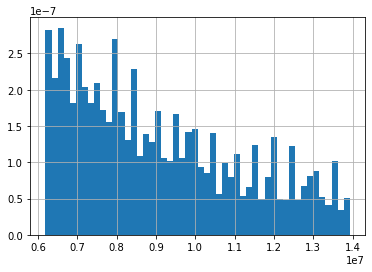

In [52]:
df[(df['Цена'] >= np.percentile(df['Цена'], 25)) & 
    (df['Цена'] <= np.percentile(df['Цена'], 75))]['Цена'].hist(bins=50, density=True)
plt.show()

Гистограмма имеет очень рваный характер.
Это обусловлено желанием пользователей объявить более "красивую" (округленную) цену.
Такое распределение отрицательно скажется на точность работы моделей машинного обуения, так как абсолютно разные объекты обладают одинаковой стоимостью.

Нивелирование такого распределения можно достич введя в рассмотрение стоимость квадратного метра.
С этой целью сперва необходимо обработать соответствующие столбцы датафрейма.

In [53]:
for i in ['Общая_площадь', 'Жилая_площадь', 'Высота_потолков']:
    df[i] = df[i].replace({'no_info': 0})
    df.loc[df[i] != 0, i] = df[i].str.split(' ', expand=True)[0]
    df[i] = df[i].astype('float')

Так как общая площадь стоит в знаменателе при расчете ее стоимости, необходимо исключить объекты с нулевым значением указанного параметра. 

In [54]:
len(df[df['Общая_площадь'] == 0]) / len(df)

0.0005203725867721289

Таких значений менее 0,1%. Можем смело отбрасывать.

In [55]:
df = df.drop(df[df['Общая_площадь'] == 0].index)

df['Цена_кв_м'] = df['Цена'] / df['Общая_площадь']

df['Цена_кв_м'].describe()

count    1.920700e+04
mean     2.402381e+05
std      2.147889e+06
min      1.297847e+02
25%      1.641444e+05
50%      1.981651e+05
75%      2.509515e+05
max      2.571429e+08
Name: Цена_кв_м, dtype: float64

Здесь так же присутсвуют выбросы.
Для принятия окончательного решения (какую цену использовать) построим вместе графики цены в целом и цены за кв.м. 

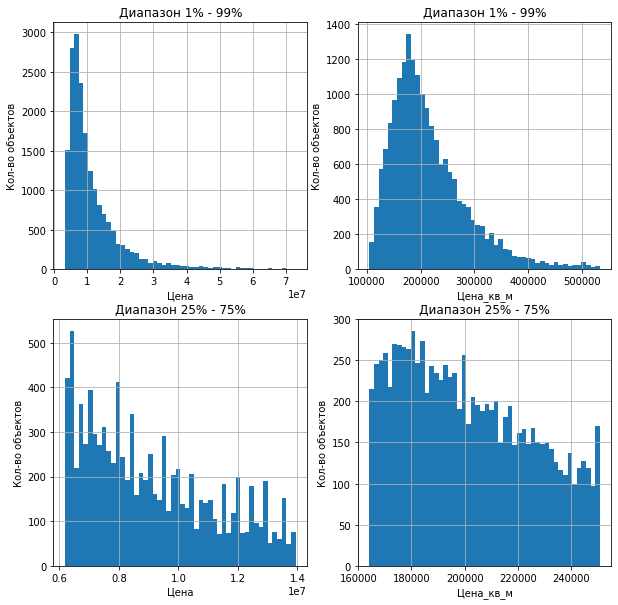

In [56]:
width = 2
height = 2
features = ['Цена', 'Цена_кв_м']
low_perc = [1, 25]
high_perc = [99, 75]

_, axs = plt.subplots(width, height, figsize=(10, 10))
for j in range(width):
    for i in range(height):
        df[(df[features[i]] >= np.percentile(df[features[i]], low_perc[j])) & 
           (df[features[i]] <= np.percentile(df[features[i]], high_perc[j]))
           ][features[i]].hist(bins=50, ax=axs[j, i]) 
        axs[j, i].set_title(f'Диапазон {low_perc[j]}% - {high_perc[j]}%')
        axs[j, i].set_xlabel(features[i])
        axs[j, i].set_ylabel('Кол-во объектов')

plt.show()

Из графиков видно, что распределение цены за кв. метр более сглаженно относительно общей цены и менее подвержено сильным выбросам.
В этой связи в качестве целевого признака для модели будем использовать именно указанный параметр.

Исключим из датафрейма объекты, выходящие из диапазона от 1 до 99 перцентиля по цене кв.м

In [57]:
df = df.drop(df[(df['Цена_кв_м'] < np.percentile(df['Цена_кв_м'], 1)) | 
                (df['Цена_кв_м'] > np.percentile(df['Цена_кв_м'], 99))].index)

In [58]:
df = df.drop('Жилая_площадь', axis=1)

Добавим категории цены квадратного метра. Это может повысить качество моделирования.

In [59]:
cost_categories = [0, 150e3, 200e3, 250e3, 300e3, float('inf')]

cost_categories_labels = [0, 1, 2, 3, 4]

df['Цена_кв_м_кат'] = pd.cut(df['Цена_кв_м'], cost_categories, labels=cost_categories_labels)

df.groupby(by='Цена_кв_м_кат')['Общая_площадь'].agg({'count', 'mean'})

,count,mean
Цена_кв_м_кат,,
0,2935,54.279898
1,6750,49.090563
2,4454,49.429704
3,2468,54.907496
4,2214,70.722584


## Добавление расстояния до центра

Построим карту объявлений с цветовой подсветкой по районам и измением размера точки от цены кв.м

In [60]:
def map_objects(feature, hue, df=df):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df, 
                    x='Долгота_Объекта', 
                    y='Широта_Объекта', 
                    hue=hue, 
                    size=feature,
                    sizes=(10,200))

    sns.scatterplot(data=df[df[feature] == df[feature].max()], 
                    x='Долгота_Объекта', 
                    y='Широта_Объекта', 
                    marker='*', 
                    s=200, 
                    color='r',
                    palette='flag',
                    label=f'Макс {feature}')
    sns.scatterplot(data=df[df[feature] == df[feature].min()], 
                    x='Долгота_Объекта', 
                    y='Широта_Объекта', 
                    marker='*', 
                    s=200, 
                    color='g',
                    palette='flag',
                    label=f'Мин {feature}')
    plt.show()

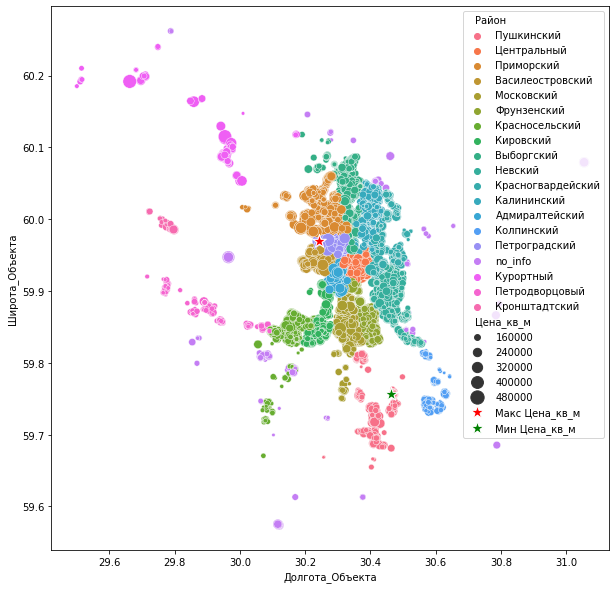

In [61]:
map_objects('Цена_кв_м', 'Район')

Построим еще сводник по средней стоимости площади в каждом районе.

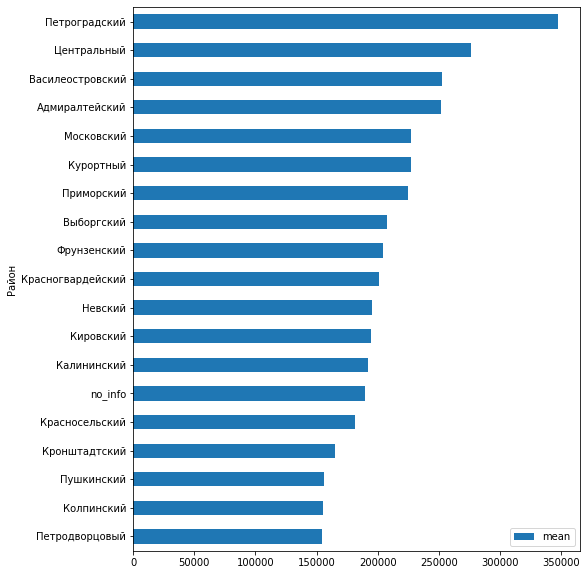

In [62]:
df.groupby(by='Район')['Цена_кв_м'].agg({'mean'}).sort_values(by='mean').plot(figsize=(8,10), kind="barh")
plt.show()

Самая дорогая площадь находится в Петроградском районе, а самая дешевая - в Пушкинском.
В качестве центра можно использовать координаты метро Крестовский остров.
Однако расчет расстояния объекта до указанной станции выполнен в предыдущем разделе.

В этой связи, дополнительный расчет до центра вводить не будем.

Введение координат до каждой станции метро позволяет исключить из рассмотрения признаки Района и ВМО

In [63]:
df = df.drop(['ВМО', 'Район'], axis=1)

df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Тип_участия,Срок_сдачи,Широта_Объекта,Долгота_Объекта,расстояние_до_девяткино,расстояние_до_гражданский_проспект,расстояние_до_академическая,расстояние_до_политехническая,расстояние_до_площадь_мужества,расстояние_до_лесная,расстояние_до_выборгская,расстояние_до_площадь_ленина,расстояние_до_чернышевская,расстояние_до_площадь_восстания,расстояние_до_владимирская,расстояние_до_пушкинская,расстояние_до_технологический_институт,расстояние_до_балтийская,расстояние_до_нарвская,расстояние_до_кировский_завод,расстояние_до_автово,расстояние_до_ленинский_проспект,расстояние_до_проспект_ветеранов,расстояние_до_парнас,расстояние_до_проспект_просвещения,расстояние_до_озерки,расстояние_до_удельная,расстояние_до_пионерская,расстояние_до_чёрная_речка,расстояние_до_петроградская,расстояние_до_горьковская,расстояние_до_невский_проспект,расстояние_до_сенная_площадь,расстояние_до_технологический_институт_2,расстояние_до_фрунзенская,расстояние_до_московские_ворота,расстояние_до_электросила,расстояние_до_парк_победы,расстояние_до_московская,расстояние_до_звёздная,расстояние_до_купчино,расстояние_до_беговая,расстояние_до_зенит,расстояние_до_приморская,расстояние_до_василеостровская,расстояние_до_гостиный_двор,расстояние_до_маяковская,расстояние_до_площадь_александра_невского_1,расстояние_до_елизаровская,расстояние_до_ломоносовская,расстояние_до_пролетарская,расстояние_до_обухово,расстояние_до_рыбацкое,расстояние_до_спасская,расстояние_до_достоевская,расстояние_до_лиговский_проспект,расстояние_до_площадь_александра_невского_2,расстояние_до_новочеркасская,расстояние_до_ладожская,расстояние_до_проспект_большевиков,расстояние_до_улица_дыбенко,расстояние_до_комендантский_проспект,расстояние_до_старая_деревня,расстояние_до_крестовский_остров,расстояние_до_чкаловская,расстояние_до_спортивная,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары,Цена_кв_м,Цена_кв_м_кат
0,9800000,17.10.2022 в 10:16,3,73.0,1 из 5,балкон,изолированные,0.0,раздельный,"во двор, на улицу, на солнечную сторону",косметический,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,2012.0,5.0,no_info,no_info,no_info,детская площадка,no_info,no_info,no_info,59.737926,30.461476,34.761,33.358,31.401,31.755,30.973,30.385,28.830,26.879,25.584,24.113,24.571,25.042,25.424,26.031,27.553,27.203,26.485,24.887,26.140,39.223,37.674,36.706,34.965,34.633,32.793,30.383,28.965,26.549,26.234,25.424,24.621,23.389,22.324,21.085,19.851,16.348,13.966,39.951,38.061,34.411,30.526,26.020,24.557,22.395,18.137,15.648,14.153,12.318,11.247,26.234,24.736,23.515,22.379,21.947,21.756,20.224,18.991,37.586,36.151,34.347,31.136,30.391,27.350,26.370,25.042,23.334,21.026,19.195,17.306,12.660,15.105,9.662,134246.575342,0
1,24000000,17.10.2022 в 01:22,3,85.0,3 из 5,no_info,изолированные,0.0,совмещенный,"во двор, на солнечную сторону",дизайнерский,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,no_info,5.0,no_info,открытая во дворе,no_info,закрытая территория,no_info,no_info,no_info,59.939086,30.343213,16.599,13.529,10.079,8.351,7.216,5.098,3.569,2.325,1.953,2.213,1.376,2.547,3.721,6.005,8.679,11.189,12.099,12.838,14.903,14.252,12.544,11.156,9.154,8.735,6.981,4.668,3.299,1.842,2.870,3.721,4.636,5.963,7.194,8.427,10.312,11.783,12.672,16.531,15.075,12.130,7.229,1.231,1.533,4.922,10.105,12.919,16.319,16.213,21.279,2.870,1.246,2.420,4.790,7.715,10.701,13.895,15.962,12.163,11.272,9.996,6.191,5.942,3.130,3.145,2.547,2.767,5.043,6.779,8.641,13.331,10.838,16.558,282352.941176,3
2,12500000,22.10.2022 в 10:29,2,55.0,8 из 12,лоджия,изолированн

## Обработка признаков с большим перечнем значений 

В некоторых признаках встречаются повторяющиеся значения.
Введем их кодирование разделением на новые признаки со значением 0/1, с последующим суммирование в один признак.

In [64]:
def my_ohe(faeture_name: str):
    '''
    Find the longest feature in column with FEATURE_NAME 
    and separate it in the list FEATURES_SEP.
    Following create the TEMP table with columns named 
    by each faeture in FEATURES_SEP and in all rows compare FEATURE_NAME 
    with each faeture in FEATURES_SEP, then mark 1 in case they match and 0 opposite
    Return convolusion by rows of the TEMP
    '''
    features = df[faeture_name].unique().tolist()
    num_of_sym = [len(x) for x in features]
    features_sep = features[num_of_sym.index(max(num_of_sym))].split(', ') 
    temp = pd.DataFrame()

    def mask(row, feature:list):
        if feature in row[faeture_name].split(', '):
            return 1
        return 0
        
    for feature in features_sep:
        temp[faeture_name + '_' + feature] = df.apply(mask, args=[feature], axis=1)

    df[faeture_name + '_свертка'] = temp.sum(axis=1)

In [65]:
large_features = ['Балкон_или_лоджия', 'Вид_сделки', 'В_доме', 'Двор', 
                  'Мебель', 'Окна', 'Парковка', 'Санузел', 'Техника', 
                  'Тип_комнат']
                  
for i in large_features:
    my_ohe(i)
    
df = df.drop(large_features, axis=1)
df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Срок_сдачи,Широта_Объекта,Долгота_Объекта,расстояние_до_девяткино,расстояние_до_гражданский_проспект,расстояние_до_академическая,расстояние_до_политехническая,расстояние_до_площадь_мужества,расстояние_до_лесная,расстояние_до_выборгская,расстояние_до_площадь_ленина,расстояние_до_чернышевская,расстояние_до_площадь_восстания,расстояние_до_владимирская,расстояние_до_пушкинская,расстояние_до_технологический_институт,расстояние_до_балтийская,расстояние_до_нарвская,расстояние_до_кировский_завод,расстояние_до_автово,расстояние_до_ленинский_проспект,расстояние_до_проспект_ветеранов,расстояние_до_парнас,расстояние_до_проспект_просвещения,расстояние_до_озерки,расстояние_до_удельная,расстояние_до_пионерская,расстояние_до_чёрная_речка,расстояние_до_петроградская,расстояние_до_горьковская,расстояние_до_невский_проспект,расстояние_до_сенная_площадь,расстояние_до_технологический_институт_2,расстояние_до_фрунзенская,расстояние_до_московские_ворота,расстояние_до_электросила,расстояние_до_парк_победы,расстояние_до_московская,расстояние_до_звёздная,расстояние_до_купчино,расстояние_до_беговая,расстояние_до_зенит,расстояние_до_приморская,расстояние_до_василеостровская,расстояние_до_гостиный_двор,расстояние_до_маяковская,расстояние_до_площадь_александра_невского_1,расстояние_до_елизаровская,расстояние_до_ломоносовская,расстояние_до_пролетарская,расстояние_до_обухово,расстояние_до_рыбацкое,расстояние_до_спасская,расстояние_до_достоевская,расстояние_до_лиговский_проспект,расстояние_до_площадь_александра_невского_2,расстояние_до_новочеркасская,расстояние_до_ладожская,расстояние_до_проспект_большевиков,расстояние_до_улица_дыбенко,расстояние_до_комендантский_проспект,расстояние_до_старая_деревня,расстояние_до_крестовский_остров,расстояние_до_чкаловская,расстояние_до_спортивная,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка
0,9800000,17.10.2022 в 10:16,3,73.0,1 из 5,0.0,косметический,no_info,no_info,свободная,кирпичный,2012.0,5.0,no_info,no_info,no_info,no_info,59.737926,30.461476,34.761,33.358,31.401,31.755,30.973,30.385,28.830,26.879,25.584,24.113,24.571,25.042,25.424,26.031,27.553,27.203,26.485,24.887,26.140,39.223,37.674,36.706,34.965,34.633,32.793,30.383,28.965,26.549,26.234,25.424,24.621,23.389,22.324,21.085,19.851,16.348,13.966,39.951,38.061,34.411,30.526,26.020,24.557,22.395,18.137,15.648,14.153,12.318,11.247,26.234,24.736,23.515,22.379,21.947,21.756,20.224,18.991,37.586,36.151,34.347,31.136,30.391,27.350,26.370,25.042,23.334,21.026,19.195,17.306,12.660,15.105,9.662,134246.575342,0,1,0,0,1,0,3,0,1,0,1
1,24000000,17.10.2022 в 01:22,3,85.0,3 из 5,0.0,дизайнерский,no_info,no_info,свободная,кирпичный,no_info,5.0,no_info,no_info,no_info,no_info,59.939086,30.343213,16.599,13.529,10.079,8.351,7.216,5.098,3.569,2.325,1.953,2.213,1.376,2.547,3.721,6.005,8.679,11.189,12.099,12.838,14.903,14.252,12.544,11.156,9.154,8.735,6.981,4.668,3.299,1.842,2.870,3.721,4.636,5.963,7.194,8.427,10.312,11.783,12.672,16.531,15.075,12.130,7.229,1.231,1.533,4.922,10.105,12.919,16.319,16.213,21.279,2.870,1.246,2.420,4.790,7.715,10.701,13.895,15.962,12.163,11.272,9.996,6.191,5.942,3.130,3.145,2.547,2.767,5.043,6.779,8.641,13.331,10.838,16.558,282352.941176,3,0,0,0,1,0,2,1,1,0,1
2,12500000,22.10.2022 в 10:29,2,55.0,8 из 12,2.6,требует ремонта,no_info,no_info,альтернативная,панельный,1992.0,12.0,2,нет,no_info,no_info,60.005504,30.254046,21.582,18.537,15.801,12.992,12.475,10.282,11.064,1

## Обработка временных признаков

В столбце с датой публикации использованы разные способы записи дат.
Исправим переименованием, исключим время и сохраним месяц публикации (поможет в дальнейшем при пополнении базы объявлений и выделении сезонности).

In [66]:
date_rename = {
    'января':'.01.2022',
    'февраля':'.02.2022',
    'марта':'.03.2022',
    'апреля':'.04.2022',
    'мая':'.05.2022',
    'июня':'.06.2022',
    'июля':'.07.2022',
    'августа':'.08.2022',
    'сентября':'.09.2022',
    'октября':'.10.2022',
    'ноября':'.11.2022',
    'декабря':'.12.2022',
}

dates = df['Дата_публикации'].str.split(' в ', expand=True)[0]
dates = dates.str.split(' ', expand=True).replace(date_rename)
dates = dates.fillna('')

df['Дата_публикации'] = dates[0] + dates[1]
df['Дата_публикации'] = pd.to_datetime(df['Дата_публикации'])
df['Месяц_публикации'] = df['Дата_публикации'].dt.month
df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Срок_сдачи,Широта_Объекта,Долгота_Объекта,расстояние_до_девяткино,расстояние_до_гражданский_проспект,расстояние_до_академическая,расстояние_до_политехническая,расстояние_до_площадь_мужества,расстояние_до_лесная,расстояние_до_выборгская,расстояние_до_площадь_ленина,расстояние_до_чернышевская,расстояние_до_площадь_восстания,расстояние_до_владимирская,расстояние_до_пушкинская,расстояние_до_технологический_институт,расстояние_до_балтийская,расстояние_до_нарвская,расстояние_до_кировский_завод,расстояние_до_автово,расстояние_до_ленинский_проспект,расстояние_до_проспект_ветеранов,расстояние_до_парнас,расстояние_до_проспект_просвещения,расстояние_до_озерки,расстояние_до_удельная,расстояние_до_пионерская,расстояние_до_чёрная_речка,расстояние_до_петроградская,расстояние_до_горьковская,расстояние_до_невский_проспект,расстояние_до_сенная_площадь,расстояние_до_технологический_институт_2,расстояние_до_фрунзенская,расстояние_до_московские_ворота,расстояние_до_электросила,расстояние_до_парк_победы,расстояние_до_московская,расстояние_до_звёздная,расстояние_до_купчино,расстояние_до_беговая,расстояние_до_зенит,расстояние_до_приморская,расстояние_до_василеостровская,расстояние_до_гостиный_двор,расстояние_до_маяковская,расстояние_до_площадь_александра_невского_1,расстояние_до_елизаровская,расстояние_до_ломоносовская,расстояние_до_пролетарская,расстояние_до_обухово,расстояние_до_рыбацкое,расстояние_до_спасская,расстояние_до_достоевская,расстояние_до_лиговский_проспект,расстояние_до_площадь_александра_невского_2,расстояние_до_новочеркасская,расстояние_до_ладожская,расстояние_до_проспект_большевиков,расстояние_до_улица_дыбенко,расстояние_до_комендантский_проспект,расстояние_до_старая_деревня,расстояние_до_крестовский_остров,расстояние_до_чкаловская,расстояние_до_спортивная,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Месяц_публикации
0,9800000,2022-10-17,3,73.0,1 из 5,0.0,косметический,no_info,no_info,свободная,кирпичный,2012.0,5.0,no_info,no_info,no_info,no_info,59.737926,30.461476,34.761,33.358,31.401,31.755,30.973,30.385,28.830,26.879,25.584,24.113,24.571,25.042,25.424,26.031,27.553,27.203,26.485,24.887,26.140,39.223,37.674,36.706,34.965,34.633,32.793,30.383,28.965,26.549,26.234,25.424,24.621,23.389,22.324,21.085,19.851,16.348,13.966,39.951,38.061,34.411,30.526,26.020,24.557,22.395,18.137,15.648,14.153,12.318,11.247,26.234,24.736,23.515,22.379,21.947,21.756,20.224,18.991,37.586,36.151,34.347,31.136,30.391,27.350,26.370,25.042,23.334,21.026,19.195,17.306,12.660,15.105,9.662,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10
1,24000000,2022-10-17,3,85.0,3 из 5,0.0,дизайнерский,no_info,no_info,свободная,кирпичный,no_info,5.0,no_info,no_info,no_info,no_info,59.939086,30.343213,16.599,13.529,10.079,8.351,7.216,5.098,3.569,2.325,1.953,2.213,1.376,2.547,3.721,6.005,8.679,11.189,12.099,12.838,14.903,14.252,12.544,11.156,9.154,8.735,6.981,4.668,3.299,1.842,2.870,3.721,4.636,5.963,7.194,8.427,10.312,11.783,12.672,16.531,15.075,12.130,7.229,1.231,1.533,4.922,10.105,12.919,16.319,16.213,21.279,2.870,1.246,2.420,4.790,7.715,10.701,13.895,15.962,12.163,11.272,9.996,6.191,5.942,3.130,3.145,2.547,2.767,5.043,6.779,8.641,13.331,10.838,16.558,282352.941176,3,0,0,0,1,0,2,1,1,0,1,10
2,12500000,2022-10-22,2,55.0,8 из 12,2.6,требует ремонта,no_info,no_info,альтернативная,панельный,1992.0,12.0,2,нет,no_info,no_info,60.005504,30.254046,21.582,18.537,15.801,12.992,12.475,10.282,11.064,12

Используя Срок_сдачи и Год_постройки рассчитаем возраст постройки.
Отрицательные значения будут соответствовать неоконченному строительству.

In [67]:
def date_repairer(row):
    current_year = row['Дата_публикации'].year
    if row['Срок_сдачи'] == 'сдан':
        return 0
    if re.search('\d\d\d\d', row['Срок_сдачи']):
        return current_year - int(re.search('\d\d\d\d', row['Срок_сдачи'])[0])
    if type(row['Год_постройки']) == (float):
        if row['Год_постройки'] < 100:
            return current_year - (int(row['Год_постройки']) + 1900)
        if row['Год_постройки'] < 300:
            return current_year - (int(row['Год_постройки']) - 200 + 2000)
        return current_year - int(row['Год_постройки'])
    return 'no_info'

In [68]:
df['Возраст_дома'] = df.apply(date_repairer, axis=1)
t = df[df['Возраст_дома'] != 'no_info']

df = df.drop(t[t['Возраст_дома'] > 300].index, axis=0) #Удалим оставшийся мусор

Исключим ненужные столбцы

In [69]:
df = df.drop(['Год_постройки', 'Срок_сдачи', 'Дата_публикации'], axis=1)

## Категориальные признаки

Сделаем функцию, которая создает новый признак со значениями 0/1, соответствующим значению no_info в исходном признаке.
При этом в исходном заменяются соответствующие значения на 0.

In [70]:
def make_me_continues(feature_name):
    new_feature = feature_name + '_no_info'
    df[new_feature] = 0
    df.loc[df[feature_name] == 'no_info', new_feature] = 1

    df[feature_name] = df[feature_name].replace({
        'no_info': 0,
        'нет': 0,
        'студия': 0, 
        'свободная планировка': 0,
        '10 и больше': 10,
        'есть': 1
        })
    
    df[feature_name] = df[feature_name].astype('int')

In [71]:
features_continues = [
    'Грузовой_лифт', 
    'Пассажирский_лифт', 
    'Возраст_дома', 
    'Количество_комнат', 
    'Тёплый_пол'
    ]

for i in features_continues:
    make_me_continues(i)

In [72]:
df.head()

,Цена,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Широта_Объекта,Долгота_Объекта,расстояние_до_девяткино,расстояние_до_гражданский_проспект,расстояние_до_академическая,расстояние_до_политехническая,расстояние_до_площадь_мужества,расстояние_до_лесная,расстояние_до_выборгская,расстояние_до_площадь_ленина,расстояние_до_чернышевская,расстояние_до_площадь_восстания,расстояние_до_владимирская,расстояние_до_пушкинская,расстояние_до_технологический_институт,расстояние_до_балтийская,расстояние_до_нарвская,расстояние_до_кировский_завод,расстояние_до_автово,расстояние_до_ленинский_проспект,расстояние_до_проспект_ветеранов,расстояние_до_парнас,расстояние_до_проспект_просвещения,расстояние_до_озерки,расстояние_до_удельная,расстояние_до_пионерская,расстояние_до_чёрная_речка,расстояние_до_петроградская,расстояние_до_горьковская,расстояние_до_невский_проспект,расстояние_до_сенная_площадь,расстояние_до_технологический_институт_2,расстояние_до_фрунзенская,расстояние_до_московские_ворота,расстояние_до_электросила,расстояние_до_парк_победы,расстояние_до_московская,расстояние_до_звёздная,расстояние_до_купчино,расстояние_до_беговая,расстояние_до_зенит,расстояние_до_приморская,расстояние_до_василеостровская,расстояние_до_гостиный_двор,расстояние_до_маяковская,расстояние_до_площадь_александра_невского_1,расстояние_до_елизаровская,расстояние_до_ломоносовская,расстояние_до_пролетарская,расстояние_до_обухово,расстояние_до_рыбацкое,расстояние_до_спасская,расстояние_до_достоевская,расстояние_до_лиговский_проспект,расстояние_до_площадь_александра_невского_2,расстояние_до_новочеркасская,расстояние_до_ладожская,расстояние_до_проспект_большевиков,расстояние_до_улица_дыбенко,расстояние_до_комендантский_проспект,расстояние_до_старая_деревня,расстояние_до_крестовский_остров,расстояние_до_чкаловская,расстояние_до_спортивная,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Пассажирский_лифт_no_info,Возраст_дома_no_info,Количество_комнат_no_info,Тёплый_пол_no_info
0,9800000,3,73.0,1 из 5,0.0,косметический,0,no_info,свободная,кирпичный,5.0,0,0,no_info,59.737926,30.461476,34.761,33.358,31.401,31.755,30.973,30.385,28.830,26.879,25.584,24.113,24.571,25.042,25.424,26.031,27.553,27.203,26.485,24.887,26.140,39.223,37.674,36.706,34.965,34.633,32.793,30.383,28.965,26.549,26.234,25.424,24.621,23.389,22.324,21.085,19.851,16.348,13.966,39.951,38.061,34.411,30.526,26.020,24.557,22.395,18.137,15.648,14.153,12.318,11.247,26.234,24.736,23.515,22.379,21.947,21.756,20.224,18.991,37.586,36.151,34.347,31.136,30.391,27.350,26.370,25.042,23.334,21.026,19.195,17.306,12.660,15.105,9.662,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10,10,1,1,0,0,1
1,24000000,3,85.0,3 из 5,0.0,дизайнерский,0,no_info,свободная,кирпичный,5.0,0,0,no_info,59.939086,30.343213,16.599,13.529,10.079,8.351,7.216,5.098,3.569,2.325,1.953,2.213,1.376,2.547,3.721,6.005,8.679,11.189,12.099,12.838,14.903,14.252,12.544,11.156,9.154,8.735,6.981,4.668,3.299,1.842,2.870,3.721,4.636,5.963,7.194,8.427,10.312,11.783,12.672,16.531,15.075,12.130,7.229,1.231,1.533,4.922,10.105,12.919,16.319,16.213,21.279,2.870,1.246,2.420,4.790,7.715,10.701,13.895,15.962,12.163,11.272,9.996,6.191,5.942,3.130,3.145,2.547,2.767,5.043,6.779,8.641,13.331,10.838,16.558,282352.941176,3,0,0,0,1,0,2,1,1,0,1,10,0,1,1,1,0,1
2,12500000,2,55.0,8 из 12,2.6,требует ремонта,0,no_info,альтернативная,панельный,12.0,2,0,no_info,60.005504,30.254046,21.582,18.537,15.801,12.992,12.475,10.282,11.064,12.619,13.577,

## Обработка этажей

In [73]:
df['Этаж'] = df['Этаж'].replace({'no_info': 0})
df.loc[df['Этаж'] != 0, 'Этаж'] = df['Этаж'].str.split(' ', expand=True)[0]
df['Этаж'] = df['Этаж'].astype('int')

In [74]:
df = df.drop('Этажей_в_доме', axis=1)

In [75]:
df.head()

,Цена,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Широта_Объекта,Долгота_Объекта,расстояние_до_девяткино,расстояние_до_гражданский_проспект,расстояние_до_академическая,расстояние_до_политехническая,расстояние_до_площадь_мужества,расстояние_до_лесная,расстояние_до_выборгская,расстояние_до_площадь_ленина,расстояние_до_чернышевская,расстояние_до_площадь_восстания,расстояние_до_владимирская,расстояние_до_пушкинская,расстояние_до_технологический_институт,расстояние_до_балтийская,расстояние_до_нарвская,расстояние_до_кировский_завод,расстояние_до_автово,расстояние_до_ленинский_проспект,расстояние_до_проспект_ветеранов,расстояние_до_парнас,расстояние_до_проспект_просвещения,расстояние_до_озерки,расстояние_до_удельная,расстояние_до_пионерская,расстояние_до_чёрная_речка,расстояние_до_петроградская,расстояние_до_горьковская,расстояние_до_невский_проспект,расстояние_до_сенная_площадь,расстояние_до_технологический_институт_2,расстояние_до_фрунзенская,расстояние_до_московские_ворота,расстояние_до_электросила,расстояние_до_парк_победы,расстояние_до_московская,расстояние_до_звёздная,расстояние_до_купчино,расстояние_до_беговая,расстояние_до_зенит,расстояние_до_приморская,расстояние_до_василеостровская,расстояние_до_гостиный_двор,расстояние_до_маяковская,расстояние_до_площадь_александра_невского_1,расстояние_до_елизаровская,расстояние_до_ломоносовская,расстояние_до_пролетарская,расстояние_до_обухово,расстояние_до_рыбацкое,расстояние_до_спасская,расстояние_до_достоевская,расстояние_до_лиговский_проспект,расстояние_до_площадь_александра_невского_2,расстояние_до_новочеркасская,расстояние_до_ладожская,расстояние_до_проспект_большевиков,расстояние_до_улица_дыбенко,расстояние_до_комендантский_проспект,расстояние_до_старая_деревня,расстояние_до_крестовский_остров,расстояние_до_чкаловская,расстояние_до_спортивная,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Пассажирский_лифт_no_info,Возраст_дома_no_info,Количество_комнат_no_info,Тёплый_пол_no_info
0,9800000,3,73.0,1,0.0,косметический,0,no_info,свободная,кирпичный,0,0,no_info,59.737926,30.461476,34.761,33.358,31.401,31.755,30.973,30.385,28.830,26.879,25.584,24.113,24.571,25.042,25.424,26.031,27.553,27.203,26.485,24.887,26.140,39.223,37.674,36.706,34.965,34.633,32.793,30.383,28.965,26.549,26.234,25.424,24.621,23.389,22.324,21.085,19.851,16.348,13.966,39.951,38.061,34.411,30.526,26.020,24.557,22.395,18.137,15.648,14.153,12.318,11.247,26.234,24.736,23.515,22.379,21.947,21.756,20.224,18.991,37.586,36.151,34.347,31.136,30.391,27.350,26.370,25.042,23.334,21.026,19.195,17.306,12.660,15.105,9.662,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10,10,1,1,0,0,1
1,24000000,3,85.0,3,0.0,дизайнерский,0,no_info,свободная,кирпичный,0,0,no_info,59.939086,30.343213,16.599,13.529,10.079,8.351,7.216,5.098,3.569,2.325,1.953,2.213,1.376,2.547,3.721,6.005,8.679,11.189,12.099,12.838,14.903,14.252,12.544,11.156,9.154,8.735,6.981,4.668,3.299,1.842,2.870,3.721,4.636,5.963,7.194,8.427,10.312,11.783,12.672,16.531,15.075,12.130,7.229,1.231,1.533,4.922,10.105,12.919,16.319,16.213,21.279,2.870,1.246,2.420,4.790,7.715,10.701,13.895,15.962,12.163,11.272,9.996,6.191,5.942,3.130,3.145,2.547,2.767,5.043,6.779,8.641,13.331,10.838,16.558,282352.941176,3,0,0,0,1,0,2,1,1,0,1,10,0,1,1,1,0,1
2,12500000,2,55.0,8,2.6,требует ремонта,0,no_info,альтернативная,панельный,2,0,no_info,60.005504,30.254046,21.582,18.537,15.801,12.992,12.475,10.282,11.064,12.619,13.577,14.538,13.553,12.626,12.210,12.038,11.819,1

## Phik

In [76]:
phik_matrix = df.phik_matrix()

interval columns not set, guessing: ['Цена', 'Количество_комнат', 'Общая_площадь', 'Этаж', 'Высота_потолков', 'Тёплый_пол', 'Пассажирский_лифт', 'Грузовой_лифт', 'Широта_Объекта', 'Долгота_Объекта', 'расстояние_до_девяткино', 'расстояние_до_гражданский_проспект', 'расстояние_до_академическая', 'расстояние_до_политехническая', 'расстояние_до_площадь_мужества', 'расстояние_до_лесная', 'расстояние_до_выборгская', 'расстояние_до_площадь_ленина', 'расстояние_до_чернышевская', 'расстояние_до_площадь_восстания', 'расстояние_до_владимирская', 'расстояние_до_пушкинская', 'расстояние_до_технологический_институт', 'расстояние_до_балтийская', 'расстояние_до_нарвская', 'расстояние_до_кировский_завод', 'расстояние_до_автово', 'расстояние_до_ленинский_проспект', 'расстояние_до_проспект_ветеранов', 'расстояние_до_парнас', 'расстояние_до_проспект_просвещения', 'расстояние_до_озерки', 'расстояние_до_удельная', 'расстояние_до_пионерская', 'расстояние_до_чёрная_речка', 'расстояние_до_петроградская', 'расс

Not enough unique value for variable Количество_комнат_no_info for analysis 1. Dropping this column


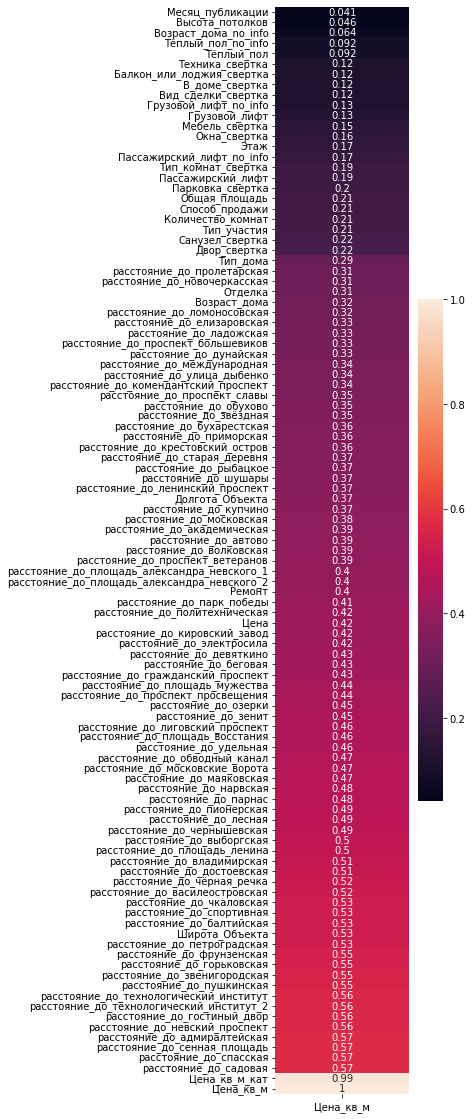

In [77]:
y = ['Цена_кв_м']

plt.figure(figsize=(3, 20))
sns.heatmap(phik_matrix[y].sort_values(by=y), annot=True)
plt.show()

Исключим все признаки с корреляцией меньше 0,1.

In [78]:
X_phik = phik_matrix[phik_matrix['Цена_кв_м'] > 0.1]['Цена_кв_м'].index.tolist()

df = df[X_phik]

Посмотрим на полную матрицу фик

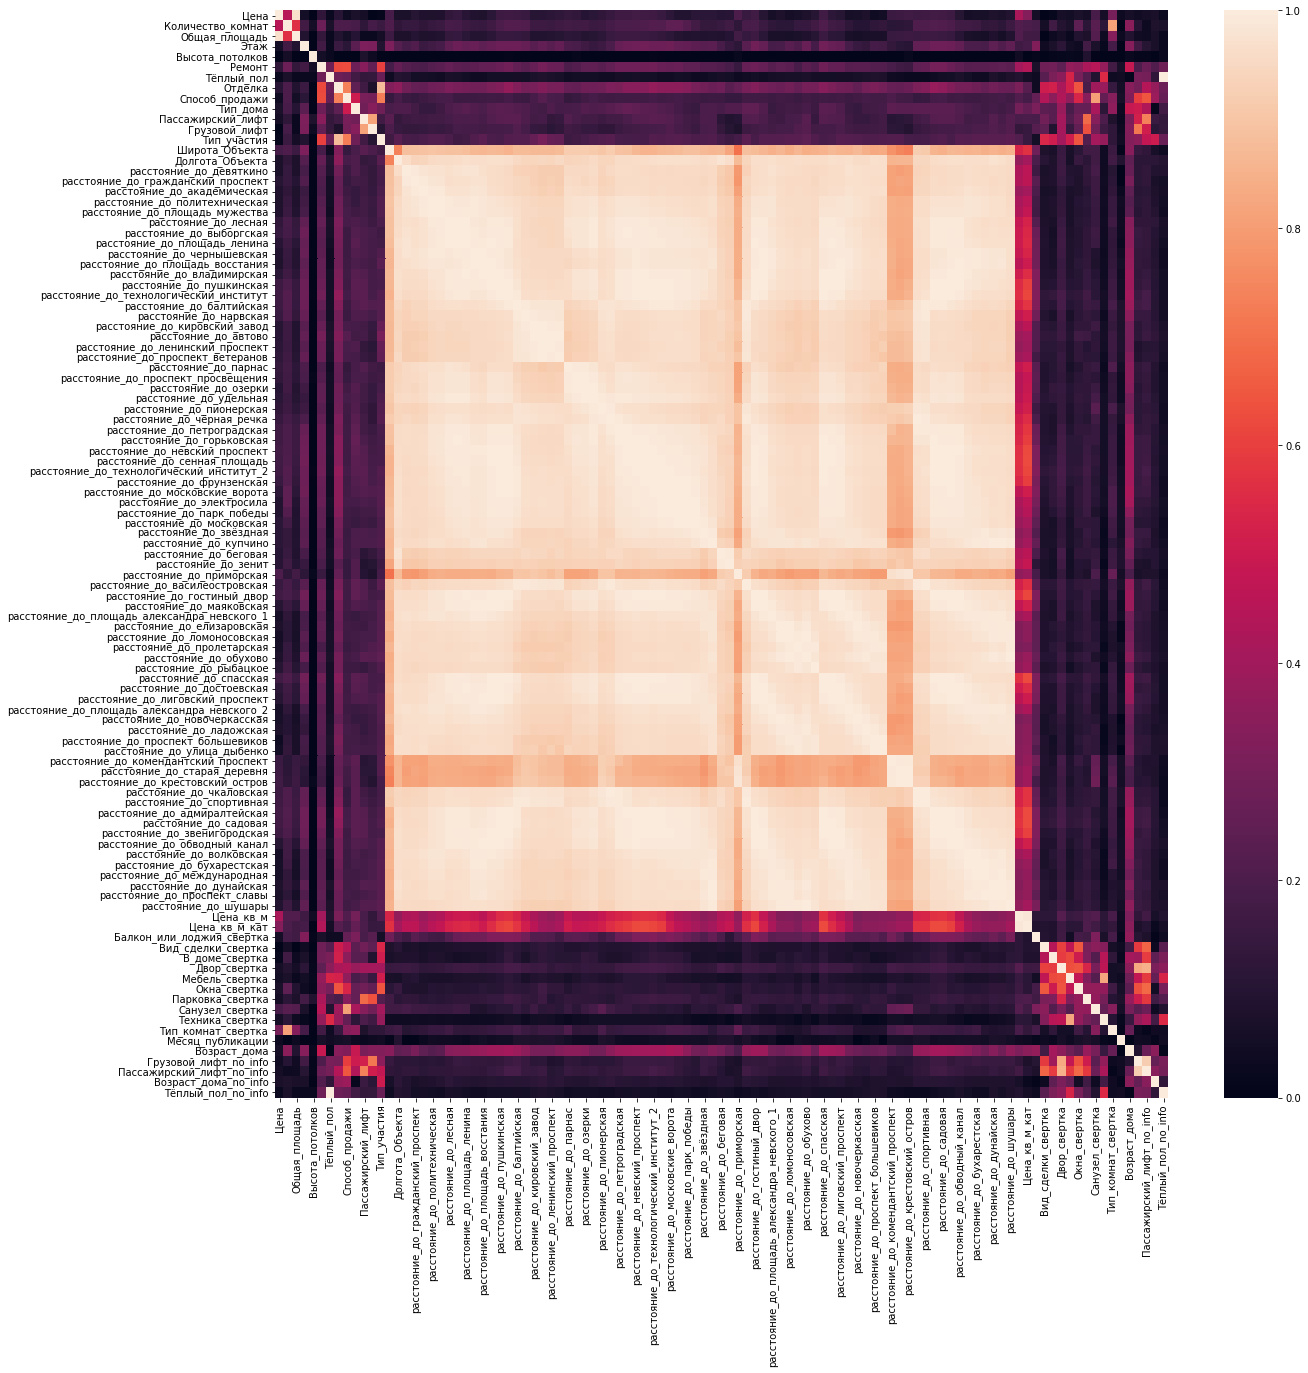

In [79]:
plt.figure(figsize=(20, 20))
sns.heatmap(phik_matrix)
plt.show()

Сильная мультиколлинеарность. Использовать линейные модели нельзя.

# Baseline - Human learning

In [80]:
SEED = 26

In [81]:
train, test = train_test_split(df, test_size=.2, random_state=SEED)

y = ['Цена_кв_м']

square_categories = [0, 30, 40, 50, 60, 70, float('inf')]

train['Общая_площадь_кат'] = pd.cut(train['Общая_площадь'], square_categories)
test['Общая_площадь_кат'] = pd.cut(test['Общая_площадь'], square_categories)

learning_mask = train.groupby(by='Общая_площадь_кат')[y].agg('median').reset_index()

test = test.merge(learning_mask, how='left', on='Общая_площадь_кат', suffixes=('', '_pred'))

mean_absolute_percentage_error(test['Цена_кв_м'], test['Цена_кв_м_pred'])

0.23358830480146905

# Catboost

In [82]:
def ohe_transformer(df, cat_features, encoder, encoder_columns):
    ohe = encoder.transform(df[cat_features])
    ohe = pd.DataFrame(ohe, columns=encoder_columns, index=df.index)
    ohe = df.drop(cat_features, axis=1).join(ohe)#.astype('int')
    return ohe


def ohe(train, test, cat_features):
    encoder = OneHotEncoder(drop="first", sparse=False)
    encoder.fit(train[cat_features])
    encoder_columns = ["_".join(x.split()) for x in encoder.get_feature_names_out()]
    return ohe_transformer(
        train, cat_features, encoder, encoder_columns
    ), ohe_transformer(test, cat_features, encoder, encoder_columns)

## Classifier

In [83]:
train, test = train_test_split(df, test_size=.2, random_state=SEED)

In [84]:
y_cl = ['Цена_кв_м_кат']

cat_features_cb = [
    'Ремонт', 
    'Отделка',
    'Способ_продажи',
    'Тип_дома', 
    'Тип_участия', 
    ]

train_ohe, test_ohe = ohe(train, test, cat_features_cb)

train_cl, train_reg = train_test_split(train_ohe, test_size=.5, random_state=SEED)

In [85]:
X_cl = train_cl.drop(y + y_cl + ['Цена'], axis=1).columns.tolist()

pool_train_cl = Pool(
    train_cl[X_cl], 
    train_cl[y_cl],
    )

In [ ]:
params = {
    "learning_rate": 0.2,
    'custom_loss':['Accuracy'],
    "loss_function": "MultiClass",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_cl = cv(
    pool=pool_train_cl,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 1.4812012	test: 1.4852767	best: 1.4852767 (0)	total: 167ms	remaining: 2m 46s
250:	learn: 0.5634254	test: 0.9196676	best: 0.9191928 (248)	total: 22.7s	remaining: 1m 7s


In [ ]:
cv_cl[0]['test-Accuracy-mean'].max(), cv_cl[0]['test-Accuracy-std'].min()

(0.6501932116296925, 0.002177746567076391)

In [ ]:
def predictor(model, df):
    t = model.predict(df[X_cl])
    return np.array([t[x].tolist().index(t[x].max()) for x in range(len(t))])

In [ ]:
train_cl['y_cl_pred'] = predictor(cv_cl[1][0], train_cl)
train_reg['y_cl_pred'] = predictor(cv_cl[1][0], train_reg)
test_ohe['y_cl_pred'] = predictor(cv_cl[1][0], test_ohe)

In [ ]:
print(classification_report(train_cl[y_cl], train_cl['y_cl_pred']))

## Regressor

In [ ]:
X_reg = X_cl + ['y_cl_pred']

pool_train_reg = Pool(
    train_reg[X_reg], 
    train_reg[y],
    )

pool_test = Pool(
    test_ohe[X_reg], 
    test_ohe[y_cl],
    )

In [ ]:
%%time

params = {
    "learning_rate": 0.8,
    "eval_metric": "MAPE",
    "loss_function": "MAPE",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_reg = cv(
    pool=pool_train_reg,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

In [ ]:
cv_reg[0]['test-MAPE-mean'].min(), cv_reg[0]['test-MAPE-std'].min()

(0.18906280534550665, 0.00122380895804591)

In [ ]:
def shap_plot(model, train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train)
    shap.summary_plot(shap_values, train, plot_size=(15, 8))

In [ ]:
shap_plot(cv_reg[1][4], train_reg[X_reg])

# Optuna

## Classifier

In [ ]:
def objective_cb_cl(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        'custom_loss':['Accuracy'],
        "loss_function": "MultiClass",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "depth": trial.suggest_int("depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "used_ram_limit": "8gb",
    }

    cv_cl = cv(
        pool=pool_train_cl,
        params=params,
        fold_count=5,
        shuffle=True,
        verbose=250,
        return_models=True,
    )
    
    return cv_cl[0]['test-Accuracy-mean'].max()

In [ ]:
я стоп строка

In [96]:
%%time
study_cb_cl = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb_cl.optimize(objective_cb_cl, n_trials=20, show_progress_bar=True)

[I 2022-12-02 04:15:40,724] A new study created in memory with name: no-name-db8ab275-deb7-4e44-be58-28b5d685b143
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]
0:	learn: 1.3873336	test: 1.3953066	best: 1.3953066 (0)	total: 180ms	remaining: 3m
250:	learn: 0.3012978	test: 0.9398686	best: 0.9291700 (121)	total: 38.6s	remaining: 1m 55s

bestTest = 0.9291700338
bestIteration = 121

Training on fold [1/5]
0:	learn: 1.3904082	test: 1.3881877	best: 1.3881877 (0)	total: 156ms	remaining: 2m 35s
250:	learn: 0.3071364	test: 0.8741263	best: 0.8663557 (181)	total: 38.3s	remaining: 1m 54s

bestTest = 0.8663557194
bestIteration = 181

Training on fold [2/5]
0:	learn: 1.3759470	test: 1.3769474	best: 1.3769474 (0)	total: 157ms	remaining: 2m 36s
250:	learn: 0.3103443	test: 0.8904254	best: 0.8859069 (236)	total: 38.3s	remaining: 1m 54s

bestTest = 0.8859068748
bestIteration = 236

Training on fold [3/5]
0:	learn: 1.3797719	test: 1.3936746	best: 1.3936746 (0)	total: 157ms	remaining: 2m 36s
250:	learn: 0.3093938	test: 0.8978889	best: 0.8907984 (143)	total: 38.3s	remaining: 1m 54s

bestTest = 0.8907983852
bestIteration = 143

Training on fold

[I 2022-12-02 06:11:47,501] Trial 15 finished with value: 0.6501964804063316 and parameters: {'learning_rate': 0.10932252319603704, 'depth': 5, 'min_data_in_leaf': 10}. Best is trial 15 with value: 0.6501964804063316.

In [ ]:
params = {
    "learning_rate": 0.1093,
    'custom_loss':['Accuracy'],
    "loss_function": "MultiClass",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
    "depth": 5,
    "min_data_in_leaf": 10,
    "used_ram_limit": "8gb",
}

cv_cl = cv(
    pool=pool_train_cl,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

## Regressor

In [ ]:
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

In [433]:
def objective_cb(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
#        "depth": trial.suggest_int("depth", 3, 10),
#        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train_bl,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

In [434]:
%%time
study_cb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb.optimize(objective_cb, n_trials=20, show_progress_bar=True)

[I 2022-11-30 22:29:54,031] A new study created in memory with name: no-name-30a642e0-dfdb-4163-bff5-35c526435370


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.1528639792
bestIteration = 849

Training on fold [1/5]

bestTest = 0.1664587275
bestIteration = 893

Training on fold [2/5]

bestTest = 0.1635082986
bestIteration = 928

Training on fold [3/5]

bestTest = 0.1656827777
bestIteration = 737

Training on fold [4/5]

bestTest = 0.1623323141
bestIteration = 951

[I 2022-11-30 22:31:21,576] Trial 0 finished with value: 0.16253882356615032 and parameters: {'learning_rate': 0.37714145736247373, 'colsample_bylevel': 0.05674523313747707, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.16253882356615032.
Training on fold [0/5]

bestTest = 0.2269548393
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2310289662
bestIteration = 994

Training on fold [2/5]

bestTest = 0.2283589041
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2333324816
bestIteration = 999

Training on fold [4/5]

bestTest = 0.2255570262
bestIteration = 999

[I 2022-11-30 22:31:48

CatBoost is using more CPU RAM (1.64GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.64GiB) than the limit (1.5GiB)



bestTest = 0.1515786181
bestIteration = 993

Training on fold [2/5]


CatBoost is using more CPU RAM (1.76GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.76GiB) than the limit (1.5GiB)



bestTest = 0.1591396239
bestIteration = 995

Training on fold [3/5]


CatBoost is using more CPU RAM (1.76GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.76GiB) than the limit (1.5GiB)



bestTest = 0.1599683203
bestIteration = 965

Training on fold [4/5]


CatBoost is using more CPU RAM (1.97GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.97GiB) than the limit (1.5GiB)



bestTest = 0.1546588325
bestIteration = 975

[I 2022-11-30 23:32:17,726] Trial 7 finished with value: 0.1551172357942032 and parameters: {'learning_rate': 0.19737577875235096, 'colsample_bylevel': 0.06694527030323656, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.42824768280280123}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)



bestTest = 0.2117572088
bestIteration = 17

Training on fold [1/5]


CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)



bestTest = 0.2173060179
bestIteration = 17

Training on fold [2/5]


CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)



bestTest = 0.2203999738
bestIteration = 36

Training on fold [3/5]


CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)



bestTest = 0.2175744639
bestIteration = 20

Training on fold [4/5]


CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)



bestTest = 0.2178563926
bestIteration = 8

[I 2022-11-30 23:32:23,528] Trial 8 finished with value: 0.21698079955506427 and parameters: {'learning_rate': 0.9781525853636923, 'colsample_bylevel': 0.08042060553967995, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.98GiB) than the limit (1.5GiB)



bestTest = 0.1519995819
bestIteration = 998

Training on fold [1/5]


CatBoost is using more CPU RAM (1.85GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.85GiB) than the limit (1.5GiB)



bestTest = 0.160052378
bestIteration = 936

Training on fold [2/5]


CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)



bestTest = 0.1648046061
bestIteration = 900

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1629789594
bestIteration = 992

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1544294799
bestIteration = 999

[I 2022-11-30 23:57:09,664] Trial 9 finished with value: 0.15898911233408997 and parameters: {'learning_rate': 0.5382080181198879, 'colsample_bylevel': 0.03443056362958395, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.539095554225753}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2595327039
bestIteration = 997

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2734191785
bestIteration = 997

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2751365573
bestIteration = 999

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2692919376
bestIteration = 999

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2768883029
bestIteration = 997

[I 2022-11-30 23:57:18,794] Trial 10 finished with value: 0.27085373671395907 and parameters: {'learning_rate': 0.12767777873462446, 'colsample_bylevel': 0.011310159116424606, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9227092998088247}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1610060115
bestIteration = 878

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1605316254
bestIteration = 928

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1670081527
bestIteration = 810

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1622491491
bestIteration = 609

Training on fold [4/5]


CatBoost is using more CPU RAM (1.85GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.85GiB) than the limit (1.5GiB)



bestTest = 0.1623491477
bestIteration = 759

[I 2022-12-01 00:52:52,674] Trial 11 finished with value: 0.16301001967296966 and parameters: {'learning_rate': 0.39751419455175946, 'colsample_bylevel': 0.07012203732902439, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7102241012885783}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)



bestTest = 0.2004775339
bestIteration = 994

Training on fold [1/5]


CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)



bestTest = 0.2033147088
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)



bestTest = 0.2009450192
bestIteration = 999

Training on fold [3/5]


CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.86GiB) than the limit (1.5GiB)



bestTest = 0.2020395269
bestIteration = 998

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2077652142
bestIteration = 999

[I 2022-12-01 00:56:23,643] Trial 12 finished with value: 0.20291483691902262 and parameters: {'learning_rate': 0.10211351174109456, 'colsample_bylevel': 0.04606574274418679, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.13558945554900276}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.173679661
bestIteration = 999

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1738952072
bestIteration = 987

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1781304099
bestIteration = 992

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1670713952
bestIteration = 999

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1777889467
bestIteration = 990

[I 2022-12-01 00:58:41,734] Trial 13 finished with value: 0.17412330416508037 and parameters: {'learning_rate': 0.3433287905680403, 'colsample_bylevel': 0.015496248722634897, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.991933692398569}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1642361122
bestIteration = 885

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1746066723
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1802749702
bestIteration = 944

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1783138751
bestIteration = 991

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1770069681
bestIteration = 971

[I 2022-12-01 01:09:42,833] Trial 14 finished with value: 0.17515722064031108 and parameters: {'learning_rate': 0.5673486782987804, 'colsample_bylevel': 0.07424497100183594, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1671834046
bestIteration = 999

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1719067862
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1591043458
bestIteration = 995

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1773882116
bestIteration = 996

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1691689943
bestIteration = 998

[I 2022-12-01 01:11:52,516] Trial 15 finished with value: 0.16895888437773682 and parameters: {'learning_rate': 0.5383079656785368, 'colsample_bylevel': 0.04693903280401793, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.114810822778942}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1626201262
bestIteration = 955

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1696972539
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1684047907
bestIteration = 995

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1691846875
bestIteration = 992

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.168307428
bestIteration = 995

[I 2022-12-01 01:17:37,277] Trial 16 finished with value: 0.16766659939186143 and parameters: {'learning_rate': 0.26223060680853466, 'colsample_bylevel': 0.027040250150407667, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6111384564369201}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2167377801
bestIteration = 994

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2274028666
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2136029985
bestIteration = 999

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1904467524
bestIteration = 949

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2127451893
bestIteration = 998

[I 2022-12-01 01:19:17,688] Trial 17 finished with value: 0.21221095568415588 and parameters: {'learning_rate': 0.5378712123596899, 'colsample_bylevel': 0.06584226022880801, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2734462247803018}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.25412942
bestIteration = 997

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.247376356
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2580049953
bestIteration = 999

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2560419879
bestIteration = 994

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.2607587304
bestIteration = 999

[I 2022-12-01 01:19:33,382] Trial 18 finished with value: 0.2552632948808366 and parameters: {'learning_rate': 0.23476008722623176, 'colsample_bylevel': 0.08322676603917852, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4321102680416812}. Best is trial 7 with value: 0.1551172357942032.
Training on fold [0/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1678048804
bestIteration = 996

Training on fold [1/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1790547385
bestIteration = 999

Training on fold [2/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.1795534654
bestIteration = 761

Training on fold [3/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.177842643
bestIteration = 999

Training on fold [4/5]


CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)
CatBoost is using more CPU RAM (1.87GiB) than the limit (1.5GiB)



bestTest = 0.177327971
bestIteration = 813

[I 2022-12-01 01:23:26,132] Trial 19 finished with value: 0.17649780365449613 and parameters: {'learning_rate': 0.6391941013740874, 'colsample_bylevel': 0.04829408601628709, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.1551172357942032.
CPU times: user 3h 47min 55s, sys: 1h 29min 36s, total: 5h 17min 32s
Wall time: 2h 53min 32s


[I 2022-11-30 23:32:17,726] Trial 7 finished with value: 0.1551172357942032 and parameters: {'learning_rate': 0.19737577875235096, 'colsample_bylevel': 0.06694527030323656, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.42824768280280123}. Best is trial 7 with value: 0.1551172357942032.


# EDA

## Общая площадь

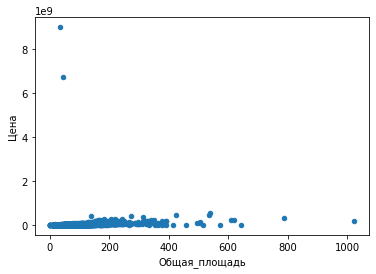

In [231]:
df.plot(x='Общая_площадь', y='Цена', kind='scatter')

In [232]:
df[df['Цена'] > 1e9]

,Цена,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,ВМО,Район,Метро_1,Метро_2,Метро_3,Широта_Объекта,Долгота_Объекта,Расстояние_Метро_1,Расстояние_Метро_2,Расстояние_Метро_3,Расстояние_Центр,Балкон_или_лоджия_балкон,Балкон_или_лоджия_лоджия,Вид_сделки_возможна ипотека,Вид_сделки_продажа доли,Вид_сделки_аукцион,В_доме_консьерж,В_доме_мусоропровод,В_доме_газ,Двор_закрытая территория,Двор_детская площадка,Двор_спортивная площадка,Мебель_кухня,Мебель_хранение одежды,Мебель_спальные места,Окна_во двор,Окна_на улицу,Окна_на солнечную сторону,Парковка_подземная,Парковка_наземная многоуровневая,Парковка_открытая во дворе,Парковка_за шлагбаумом во дворе,Санузел_совмещенный,Санузел_раздельный,Техника_холодильник,Техника_плита,Техника_микроволновка,Техника_стиральная машина,Техника_посудомоечная машина,Техника_телевизор,Техника_фен,Техника_утюг,Тип_комнат_изолированные,Тип_комнат_смежные,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Количество_комнат_свободная_планировка,Количество_комнат_no_info
14624,6750000000,2,45.0,26.0,3,2.7,косметический,0,no_info,свободная,монолитный,no_info,0,no_info,округ Ульянка,Кировский,проспект ветеранов,no_info,no_info,59.828953,30.205043,5.268375,7448.071751,7448.071751,17.355674,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10,no_info,1,0,0
16988,9000000000,1,35.0,15.2,7,2.7,евро,1,no_info,свободная,монолитно-кирпичный,2,2,no_info,Финляндский округ,Калининский,лесная,выборгская,площадь мужества,59.980992,30.374250,3.361755,3.185842,2.278190,7.993553,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,10,4,0,0,0


Однозначно выбросы - маленькая площадь и большая цена. Могут быть вызваны ошибкой ввода данных и указанием лишнего нуля.

Исключим из рассмотрения

In [233]:
df = df.drop(df[df['Цена'] > 1e9].index)

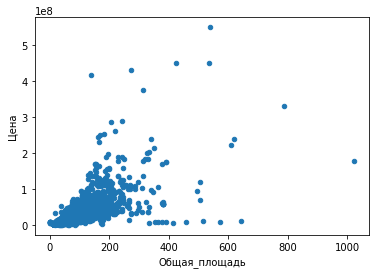

In [234]:
df.plot(x='Общая_площадь', y='Цена', kind='scatter')
plt.show()

In [235]:
df[df['Цена'] < 1e6]

,Цена,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,ВМО,Район,Метро_1,Метро_2,Метро_3,Широта_Объекта,Долгота_Объекта,Расстояние_Метро_1,Расстояние_Метро_2,Расстояние_Метро_3,Расстояние_Центр,Балкон_или_лоджия_балкон,Балкон_или_лоджия_лоджия,Вид_сделки_возможна ипотека,Вид_сделки_продажа доли,Вид_сделки_аукцион,В_доме_консьерж,В_доме_мусоропровод,В_доме_газ,Двор_закрытая территория,Двор_детская площадка,Двор_спортивная площадка,Мебель_кухня,Мебель_хранение одежды,Мебель_спальные места,Окна_во двор,Окна_на улицу,Окна_на солнечную сторону,Парковка_подземная,Парковка_наземная многоуровневая,Парковка_открытая во дворе,Парковка_за шлагбаумом во дворе,Санузел_совмещенный,Санузел_раздельный,Техника_холодильник,Техника_плита,Техника_микроволновка,Техника_стиральная машина,Техника_посудомоечная машина,Техника_телевизор,Техника_фен,Техника_утюг,Тип_комнат_изолированные,Тип_комнат_смежные,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Количество_комнат_свободная_планировка,Количество_комнат_no_info
13357,800000,1,31.2,0.0,3,0.0,требует ремонта,0,no_info,свободная,кирпичный,no_info,0,no_info,округ Пулковский меридиан,Московский,парк победы,московская,электросила,59.860012,30.315455,0.996326,1.407514,2.160680,8.781590,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12,no_info,1,0,0
13727,10850,3,83.6,46.7,11,2.7,евро,0,no_info,свободная,монолитный,1,1,no_info,Шушары,Пушкинский,купчино,шушары,звёздная,59.802544,30.379577,3.057327,6.215075,4.781520,16.740854,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10,1,0,0,0
15742,690000,3,65.0,51.0,3,0.0,косметический,0,no_info,свободная,панельный,no_info,0,no_info,Балканский округ,Фрунзенский,дунайская,купчино,шушары,59.828849,30.403930,1.437271,3.138687,3.347822,15.677774,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10,no_info,1,0,0
16690,7689,1,34.8,10.9,2,2.7,требует ремонта,0,no_info,свободная,монолитно-кирпичный,2,2,no_info,округ Морской,Василеостровский,приморская,зенит,no_info,59.941889,30.190832,4.905176,4.089506,7458.567085,13.894322,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0


Однозначно выбросы. Аналогично,вызваны ошибкой ввода данных.

Исключим из рассмотрения

In [236]:
df = df.drop(df[df['Цена'] < 1e6].index)

In [237]:
df[df['Общая_площадь'] == 0]

,Цена,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,ВМО,Район,Метро_1,Метро_2,Метро_3,Широта_Объекта,Долгота_Объекта,Расстояние_Метро_1,Расстояние_Метро_2,Расстояние_Метро_3,Расстояние_Центр,Балкон_или_лоджия_балкон,Балкон_или_лоджия_лоджия,Вид_сделки_возможна ипотека,Вид_сделки_продажа доли,Вид_сделки_аукцион,В_доме_консьерж,В_доме_мусоропровод,В_доме_газ,Двор_закрытая территория,Двор_детская площадка,Двор_спортивная площадка,Мебель_кухня,Мебель_хранение одежды,Мебель_спальные места,Окна_во двор,Окна_на улицу,Окна_на солнечную сторону,Парковка_подземная,Парковка_наземная многоуровневая,Парковка_открытая во дворе,Парковка_за шлагбаумом во дворе,Санузел_совмещенный,Санузел_раздельный,Техника_холодильник,Техника_плита,Техника_микроволновка,Техника_стиральная машина,Техника_посудомоечная машина,Техника_телевизор,Техника_фен,Техника_утюг,Тип_комнат_изолированные,Тип_комнат_смежные,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Количество_комнат_свободная_планировка,Количество_комнат_no_info
1164,6433990,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,Парголово,Выборгский,парнас,no_info,no_info,60.076417,30.289682,5.017749,7476.861347,7476.861347,15.541601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,no_info,1,0,1
4120,5915114,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Пулковский меридиан,Московский,no_info,no_info,no_info,59.776786,30.326091,7448.973471,7448.973471,7448.973471,18.066441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
4632,8300000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Шувалово-Озерки,Выборгский,проспект просвещения,озерки,парнас,60.046297,30.326226,0.906458,1.149559,2.450304,11.976246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
9473,7517653,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Смольнинское,Центральный,волковская,московские ворота,фрунзенская,59.937689,30.364602,4.696380,7.279228,6.296548,5.422420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,no_info,1,0,1
11187,7400000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Коломяги,Приморский,no_info,no_info,no_info,60.040240,30.209921,7469.283450,7469.283450,7469.283450,16.279365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
11804,8500000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,Обуховский округ,Невский,пролетарская,ломоносовская,обухово,59.862727,30.445917,2.688238,1.689962,2.038133,16.760328,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
12721,9600000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Сосновая поляна,Красносельский,no_info,no_info,no_info,59.838304,30.108366,7444.164244,7444.164244,7444.164244,25.628948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
16431,7000000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Юнтолово,Приморский,no_info,no_info,no_info,60.032807,30.197461,7467.923239,7467.923239,7467.923239,16.781830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
16658,8150000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Академическое,Калининский,политехническая,академическая,площадь мужества,60.019019,30.375229,1.218512,2.414018,2.358888,11.072094,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1
19104,4250000,0,0.0,0.0,0,0.0,no_info,0,no_info,no_info,no_info,no_info,0,no_info,округ Княжево,Кировский,проспект ветеранов,ленинский проспект,автово,59.842065,30.259436,0.983291,1.410131,2.815082,12.465668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,1


Учитывая, что общая площадь ключевой параметр - исключим и эти объекты из рассмотрения.

In [238]:
df = df.drop(df[df['Общая_площадь'] == 0].index)

In [239]:
df[df['Цена'] < 2e6]

,Цена,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,ВМО,Район,Метро_1,Метро_2,Метро_3,Широта_Объекта,Долгота_Объекта,Расстояние_Метро_1,Расстояние_Метро_2,Расстояние_Метро_3,Расстояние_Центр,Балкон_или_лоджия_балкон,Балкон_или_лоджия_лоджия,Вид_сделки_возможна ипотека,Вид_сделки_продажа доли,Вид_сделки_аукцион,В_доме_консьерж,В_доме_мусоропровод,В_доме_газ,Двор_закрытая территория,Двор_детская площадка,Двор_спортивная площадка,Мебель_кухня,Мебель_хранение одежды,Мебель_спальные места,Окна_во двор,Окна_на улицу,Окна_на солнечную сторону,Парковка_подземная,Парковка_наземная многоуровневая,Парковка_открытая во дворе,Парковка_за шлагбаумом во дворе,Санузел_совмещенный,Санузел_раздельный,Техника_холодильник,Техника_плита,Техника_микроволновка,Техника_стиральная машина,Техника_посудомоечная машина,Техника_телевизор,Техника_фен,Техника_утюг,Тип_комнат_изолированные,Тип_комнат_смежные,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Количество_комнат_свободная_планировка,Количество_комнат_no_info
3286,1690000,0,15.0,12.0,1,2.8,евро,0,no_info,свободная,панельный,нет,0,no_info,округ Княжево,Кировский,проспект ветеранов,ленинский проспект,автово,59.843900,30.261098,1.184795,1.135202,2.603356,12.196669,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,10,57,0,0,0
6915,1925000,0,12.9,0.0,2,3.4,евро,0,no_info,свободная,кирпичный,no_info,0,no_info,Екатерингофский округ,Адмиралтейский,нарвская,балтийская,фрунзенская,59.909590,30.278040,0.993354,2.408075,4.395119,5.323450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,186,1,0,0
10841,1150000,1,37.0,17.0,8,17.0,евро,0,no_info,свободная,панельный,3,2,no_info,округ Юнтолово,Приморский,комендантский проспект,пионерская,удельная,60.020543,30.266012,1.559222,3.962524,5.528040,10.616014,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,14,0,0,0
11226,1900000,3,53.3,39.7,3,0.0,косметический,0,no_info,свободная,кирпичный,no_info,0,no_info,Песочный,Курортный,no_info,no_info,no_info,60.118628,30.175794,7475.364105,7475.364105,7475.364105,25.308370,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,10,no_info,1,0,0
12120,1960000,1,73.9,0.0,1,0.0,требует ремонта,0,no_info,альтернативная,деревянный,no_info,0,no_info,Смолячково,Курортный,no_info,no_info,no_info,60.179347,29.482537,7447.180912,7447.180912,7447.180912,96.377554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,no_info,1,0,0
14065,1830000,5,87.0,0.0,3,0.0,косметический,0,no_info,альтернативная,кирпичный,no_info,0,no_info,округ Дачное,Кировский,проспект ветеранов,ленинский проспект,автово,59.835166,30.259256,1.234260,2.041444,3.581304,13.143642,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10,no_info,1,0,0
14119,1695000,0,14.3,14.3,1,3.2,евро,0,no_info,свободная,кирпичный,no_info,0,no_info,Ломоносов,Петродворцовый,no_info,no_info,no_info,59.916541,29.765246,7434.889151,7434.889151,7434.889151,61.237095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,11,3,1,0,0
14228,1699000,0,15.0,12.0,1,3.0,евро,1,no_info,свободная,кирпичный,no_info,0,no_info,округ № 7,Василеостровский,василеостровская,спортивная,приморская,59.937098,30.269174,1.178533,2.969663,4.060205,5.189001,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,10,31,1,0,0
14288,1500000,0,38.0,30.0,18,2.5,косметический,0,no_info,свободная,панельный,2,0,no_info,Шушары,Пушкинский,купчино,звёздная,шушары,59.809803,30.364269,2.558004,3.082922,7.690240,15.337052,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,10,8,1,0,0
14374,1990000,0,10.0,5.1,1,0.0,дизайнерский,1,no_info,свободная,кирпичный,no_info,0,no_info,округ Коломна,Адмиралтейский,балтийская,технологический институт 2,технологический институт,59.919085,30.289512,1.729906,3.232441,3.232441,3.669583,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,10,

Есть аналогичные несоотвтетсвия. Например, строка 14065.

Построим сводники

In [240]:
def percentile(n):
    '''
    https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
    '''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

Разделим на группы по квантилям и выведем сводную таблицу с 2ым и 98ым перцентилями.

In [241]:
labels = [x/20 for x in range(1, 21)]

df['Цена_кат'] = pd.qcut(df['Цена'], 20, labels = labels)

df.groupby(by=['Цена_кат']).agg({'Общая_площадь': ['min', 
                                                   percentile(2), 
                                                   'mean', 
                                                   percentile(98), 
                                                   'max', 
                                                   'count']})

Общая_площадь                                                     
                   min percentile_2        mean percentile_98     max count
Цена_кат                                                                   
0.05              10.0       11.032   23.433195        42.000   175.0   967
0.1               12.5       17.100   27.484365        42.496   172.8   953
0.15              15.3       18.754   29.300495        44.810    67.1  1010
0.2               14.3       20.520   33.022532        48.792    79.7  1003
0.25              15.8       20.728   35.088351        58.904   416.0   867
0.3               18.0       22.236   37.146979        58.694    72.9   960
0.35              16.0       21.800   38.917481        59.200   459.0  1064
0.4               18.4       23.262   41.865886        64.890    76.0   982
0.45              19.1       24.000   44.312581        66.400   377.0   930
0.5               21.4       24.000   45.694682        70.976   392.0   865
0.55              19.7       26.538   48.903608        77.172   573.0   970
0.6               21.2       26.976   51.347785        83.012   365.0   948
0.65              21.2       29.020   52.559209        82.240   112.0   961
0.7               23.3       32.032   58.035141        92.900   645.0   959
0.75              25.2       36.000   60.894688        96.628   266.0   960
0.8               26.9       38.726   66.343416       106.974   168.0   972
0.85              31.6       40.906   71.543711       112.940   141.3   954
0.9               36.7       44.108   82.051623       133.960   197.0   955
0.95              41.0       50.420   96.171800       177.160   272.0   961
1.0               17.1       65.254  147.620877       378.720  1024.2   958

В каждой группе есть выбросы. 
Отсеим их

In [242]:
percentile_98 = df.groupby(by=['Цена_кат']).agg({
    'Общая_площадь': percentile(98)
    })['Общая_площадь']


for i in range(len(labels)):
    df = df.drop(df[(df['Цена_кат'] == labels[i]) & 
                    ((df['Общая_площадь'] <= percentile_2[i]) | 
                     (df['Общая_площадь'] >= percentile_98[i]))].index)

In [243]:
len(df)

18386

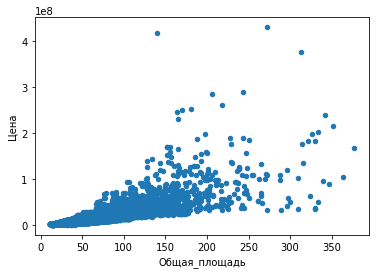

In [244]:
df.plot(x='Общая_площадь', y='Цена', kind='scatter')
plt.show()

График принял ожидаемый вид. Без больших выбросов

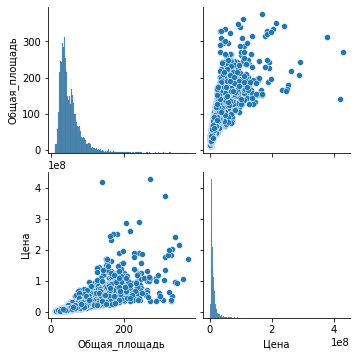

In [245]:
sns.pairplot(df[['Общая_площадь', 'Цена']])
plt.show()

### Insight

Очень длинные хвосты.  
Два варианта.  
- просто отсеить  
- ввести категории: сначала определять диапазон цен, а затем внутри этого диапазона уже определять саму стоимость

## Рассотояние до центра

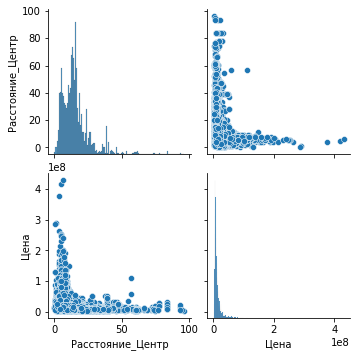

In [252]:
sns.pairplot(df[['Расстояние_Центр', 'Цена']])
plt.show()

In [253]:
df['Расстояние_Центр_кат'] = pd.qcut(df['Расстояние_Центр'], 20, labels = labels)

df.groupby(by=['Расстояние_Центр_кат']).agg({'Цена': ['min', 
                                                   percentile(2), 
                                                   'mean', 
                                                   percentile(98), 
                                                   'max', 
                                                   'count']})

Цена                                           \
                          min percentile_2          mean percentile_98   
Расстояние_Центр_кат                                                     
0.05                  2123960   2786900.00  2.447007e+07  1.223096e+08   
0.1                   1730000   3105400.00  2.149497e+07  8.346680e+07   
0.15                  1699000   3172760.00  2.272358e+07  1.078021e+08   
0.2                   2550000   4089111.20  2.271625e+07  9.178035e+07   
0.25                  1699000   4347000.00  1.776668e+07  9.022800e+07   
0.3                   1730000   4662000.00  1.585430e+07  7.608813e+07   
0.35                  1150000   4317000.00  1.072186e+07  3.180650e+07   
0.4                   1699000   4000000.00  1.146019e+07  3.796200e+07   
0.45                  1690000   4654249.52  9.847443e+06  2.360400e+07   
0.5                   1200000   4246231.76  9.895629e+06  2.246720e+07   
0.55                  2490000   4235278.70  1.046340e+07  3.070141e+07   
0.6                   1000000   3400000.00  9.356953e+06  2.267019e+07   
0.65                  1500000   3514000.00  7.976246e+06  2.089500e+07   
0.7                   2300000   4057000.00  9.955039e+06  2.544193e+07   
0.75                  2850000   4084716.40  8.248015e+06  1.712400e+07   
0.8                   2650000   3497480.00  7.374923e+06  1.655415e+07   
0.85                  2600000   3457941.00  7.793764e+06  1.935000e+07   
0.9                   3165000   3568000.00  6.683746e+06  1.396040e+07   
0.95                  2850000   3303940.00  7.150490e+06  1.609300e+07   
1.0                   1695000   3604262.40  1.203672e+07  3.123396e+07   

                                       
                            max count  
Расстояние_Центр_кат                   
0.05                  375960000   920  
0.1                   418260000   957  
0.15                  252000000   881  
0.2                   430000000   929  
0.25                  190000000   948  
0.3                   145000000   882  
0.35                  149000000   918  
0.4                    68510200   920  
0.45                   60000000   933  
0.5                    35000000   905  
0.55                   43873000   928  
0.6                    40000000   960  
0.65                   53000000   876  
0.7                    48000000   920  
0.75                   34990000   920  
0.8                    43000000   915  
0.85                   46000000   916  
0.9                    32000000   919  
0.95                   50000000   920  
1.0                   111000000   919

# Modeling

In [246]:
%%time
train, test = train_test_split(df, test_size=.25, random_state=SEED)

pool_train_bl = Pool(
    train[X_bl], 
    train[y], 
    cat_features=cat_features_bl)

pool_test_bl = Pool(
    test[X_bl], 
    test[y], 
    cat_features=cat_features_bl)

params = {
    "learning_rate": 0.5,
    "eval_metric": "MAPE",
    "loss_function": "MAPE",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_bl = cv(
    pool=pool_train_bl,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.5418682	test: 0.5381570	best: 0.5381570 (0)	total: 72.6ms	remaining: 1m 12s
250:	learn: 0.3092798	test: 0.3105629	best: 0.3105421 (237)	total: 10.3s	remaining: 30.8s
500:	learn: 0.3059143	test: 0.3080783	best: 0.3080532 (483)	total: 19.8s	remaining: 19.7s
750:	learn: 0.3047991	test: 0.3073480	best: 0.3073480 (750)	total: 31s	remaining: 10.3s
999:	learn: 0.3036782	test: 0.3070741	best: 0.3070739 (958)	total: 41s	remaining: 0us

bestTest = 0.3070738937
bestIteration = 958

Training on fold [1/5]
0:	learn: 0.5527973	test: 0.5483548	best: 0.5483548 (0)	total: 41.3ms	remaining: 41.2s
250:	learn: 0.2902328	test: 0.2998235	best: 0.2998066 (235)	total: 10.4s	remaining: 31.1s
500:	learn: 0.2869978	test: 0.2990078	best: 0.2990078 (500)	total: 23.6s	remaining: 23.5s
750:	learn: 0.2853867	test: 0.2981366	best: 0.2981366 (750)	total: 33.3s	remaining: 11s
999:	learn: 0.2850955	test: 0.2980502	best: 0.2980502 (996)	total: 41.8s	remaining: 0us

bestTest = 0.298050188

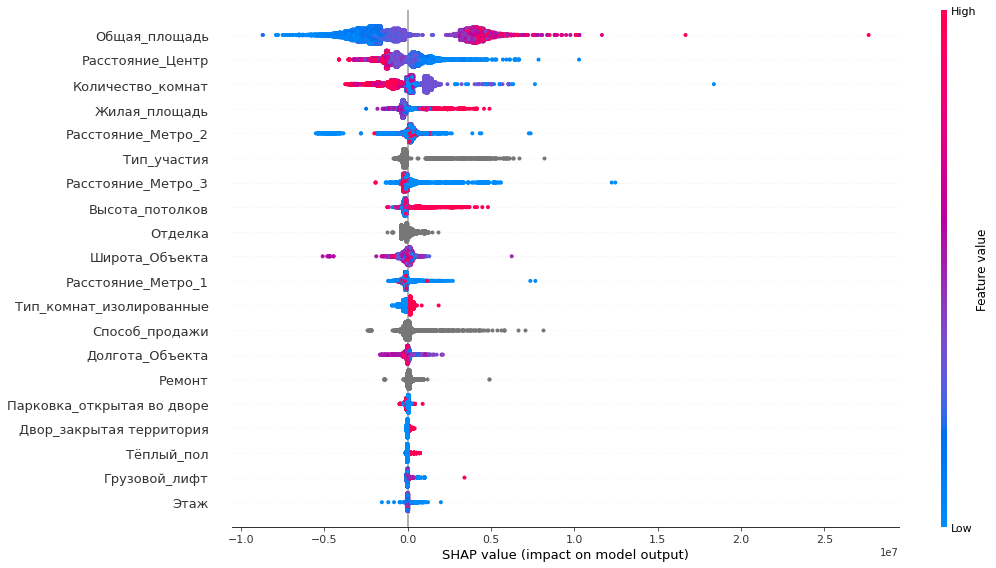

In [250]:
shap_plot(cv_bl[1][3], train)

# Baseline

In [ ]:
Я СТОП ЯЧЕЙКА

In [222]:
SEED = 26

In [223]:
y = ['Цена']
X_bl = df.drop(y, axis=1).columns.tolist()
cat_features_bl = ['Количество_комнат', 
                'Ремонт', 
                'Тёплый_пол', 
                'Отделка',
                'Способ_продажи',
                'Тип_дома', 
                'Пассажирский_лифт', 
                'Грузовой_лифт', 
                'Тип_участия', 
                'ВМО', 
                'Район',
                'Метро_1', 
                'Метро_2', 
                'Метро_3', 
                'Балкон_или_лоджия_балкон',
                'Балкон_или_лоджия_лоджия', 
                'Вид_сделки_возможна ипотека',
                'Вид_сделки_продажа доли', 
                'Вид_сделки_аукцион', 
                'В_доме_консьерж',
                'В_доме_мусоропровод', 
                'В_доме_газ', 
                'Двор_закрытая территория',
                'Двор_детская площадка', 
                'Двор_спортивная площадка', 
                'Мебель_кухня',
                'Мебель_хранение одежды', 
                'Мебель_спальные места', 
                'Окна_во двор',
                'Окна_на улицу', 
                'Окна_на солнечную сторону', 
                'Парковка_подземная',
                'Парковка_наземная многоуровневая', 
                'Парковка_открытая во дворе',
                'Парковка_за шлагбаумом во дворе', 
                'Санузел_совмещенный',
                'Санузел_раздельный', 
                'Техника_холодильник', 
                'Техника_плита',
                'Техника_микроволновка', 
                'Техника_стиральная машина',
                'Техника_посудомоечная машина', 
                'Техника_телевизор', 
                'Техника_фен',
                'Техника_утюг', 
                'Тип_комнат_изолированные', 
                'Тип_комнат_смежные',
                'Месяц_публикации', 
                'Возраст_дома', 
                'Грузовой_лифт_no_info',
                'Количество_комнат_свободная_планировка', 
                'Количество_комнат_no_info'
                ]

In [224]:
train, test = train_test_split(df, test_size=.25, random_state=SEED)

pool_train_bl = Pool(
    train[X_bl], 
    train[y], 
    cat_features=cat_features_bl)

pool_test_bl = Pool(
    test[X_bl], 
    test[y], 
    cat_features=cat_features_bl)

In [93]:
%%time

params = {
    "learning_rate": 0.5,
    "eval_metric": "MAPE",
    "loss_function": "MAPE",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_bl = cv(
    pool=pool_train_bl,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.6336328	test: 0.5978674	best: 0.5978674 (0)	total: 96.9ms	remaining: 1m 36s
250:	learn: 0.3206721	test: 0.3390256	best: 0.3390256 (250)	total: 8.81s	remaining: 26.3s
500:	learn: 0.3076745	test: 0.3309909	best: 0.3309698 (499)	total: 17.5s	remaining: 17.5s
750:	learn: 0.2999733	test: 0.3274342	best: 0.3273491 (741)	total: 26.7s	remaining: 8.84s
999:	learn: 0.2948760	test: 0.3255134	best: 0.3255134 (999)	total: 35.7s	remaining: 0us

bestTest = 0.3255133803
bestIteration = 999

Training on fold [1/5]
0:	learn: 0.6020034	test: 0.5760440	best: 0.5760440 (0)	total: 42.8ms	remaining: 42.8s
250:	learn: 0.2897672	test: 0.3018330	best: 0.3018330 (250)	total: 9.22s	remaining: 27.5s
500:	learn: 0.2769184	test: 0.2950926	best: 0.2948884 (493)	total: 18.6s	remaining: 18.5s
750:	learn: 0.2719323	test: 0.2934674	best: 0.2934642 (742)	total: 28.1s	remaining: 9.32s
999:	learn: 0.2667712	test: 0.2909381	best: 0.2909381 (998)	total: 37.5s	remaining: 0us

bestTest = 0.290

In [247]:
def shap_plot(model, train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train[X_bl])
    shap.summary_plot(shap_values, train[X_bl], plot_size=(15, 8))

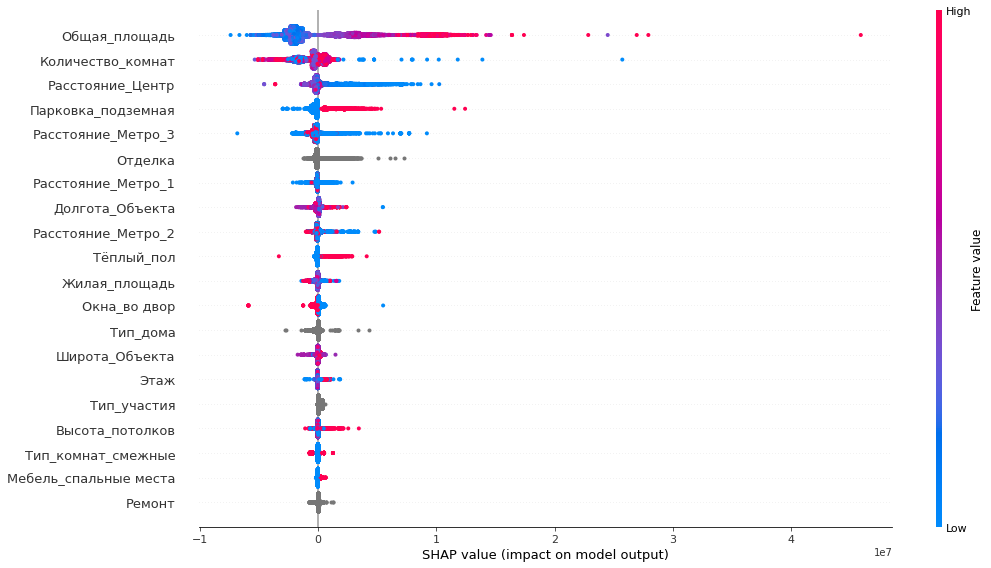

In [248]:
shap_plot(cv_bl[1][1], train)